# Student Name: Kanav Jamwal
# Student ID: 29554209

# Part B. Neural Network vs. Perceptron
## Neural Network’s Decision Boundary

In [1]:
set.seed(1234)          # set random seed
library(ggplot2)        # load libraries

In [2]:
####################### GENERAL AUXILIARY FUNCTIONS #######################
## The following structure helps us to have functions with multiple outputs
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html
list <- structure(NA,class="result")
"[<-.result" <- function(x,...,value) {
  args <- as.list(match.call())
  args <- args[-c(1:2,length(args))]
  length(value) <- length(args)
  for(i in seq(along=args)) {
    a <- args[[i]]
    if(!missing(a)) eval.parent(substitute(a <- v,list(a=a,v=value[[i]])))
  }
  x
}

# reading the data
read.data <- function(file.name, scaling=FALSE) {
  data <- read.csv(file=file.name,head=TRUE,sep=",")
  data <- data[complete.cases(data),] # removes rows with NA values
  D <- ncol(data)
  x = data[,-D]
  y = data[,D]
  if (isTRUE(scaling)) {
    x = scale(x)
    y = scale(y)
  }
  return (list('x' = x, 'y' = y))
}

error.rate <- function(Y1, T1){
  if (length(Y1)!=length(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/length(T1))
}

## 1. Data loading and Plot

In [3]:
####################### Assignment 3.B #######################
# Read the datasets
list[X1,T1] <- read.data('./Task2B_train.csv') # read training data
T1[T1==0] <- -1         # convert 0 labels to -1 

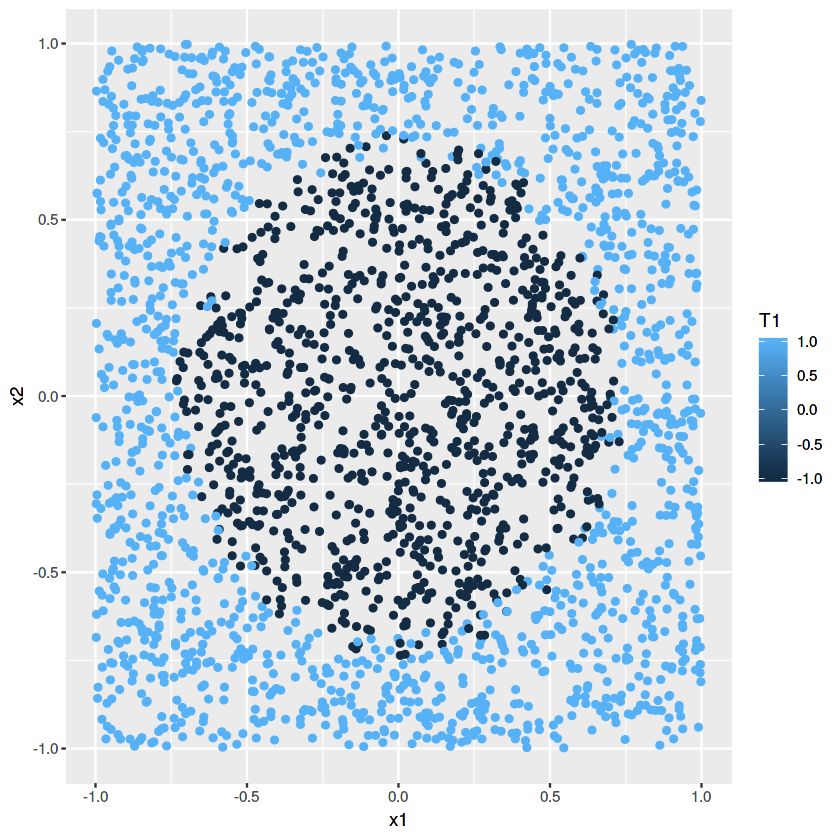

In [4]:
#? Plot training dataset (TO BE COMPLETE)
ggplot(cbind(X1,T1))+geom_point(aes(x=x1,y=x2,color=T1))

## 2. Perceptron

In [5]:
####################### PERCEPTRON #######################
## prediction
perceptron.predict <- function(Phi, W){
  return(ifelse(Phi%*%W>=0, +1, -1))
}
## is it a misclassification? if yes, update the weight vector
is.a.miss <- function(Phi, W, T1){
  return((W%*%Phi)*T1<0)
}


## Perceptron Build function
perceptron.build <- function(X1, T1, eta=0.01, epsilon=0.001, tau.max=100, plotting=FALSE){
  if (length(unique(T1))!=2){
    stop("Perceptron: The input data is not a binary classification problem.")
  }
  if (all(sort(unique(T1)) != c(-1, 1))) {
    stop("Perceptron: The labels are not (-1, +1).")
  }
  
  N1 <- nrow(X1)
  Phi <- as.matrix(cbind(1, X1)) # add a column of 1 as phi_0

  W <- matrix(NA,nrow=tau.max, ncol=ncol(Phi)) # Empty Weight vector
  W[1,] <- 2*runif(ncol(Phi))-1 # Random initial values for weight vector
  error.rec <- matrix(NA,nrow=tau.max, ncol=1) # Placeholder for errors
  error.rec[1] <- error.rate(perceptron.predict(Phi, W[1,]), T1) # record error for initial weights
  tau <- 1 # iteration counter 
  terminate <- FALSE # termination status
  
  while(!terminate){
    # resuffling train data and associated labels:
    indx <- sample(1:N1, replace = FALSE)
    Phi <- Phi[indx,]
    T1 <- T1[indx]
    
    for (i in 1:N1){
      if (tau >= tau.max) {break}
      # look for missclassified samples
      if (is.a.miss(Phi[i,], W[tau,], T1[i])){
        tau <- tau +1                                 # update tau counter
        W[tau,] <- W[tau-1,] + eta * Phi[i,] * T1[i]  # update the weights
        error.rec[tau] <- error.rate(perceptron.predict(Phi, W[tau,]), T1)# update the records
        eta = eta * 0.99                                 # decrease eta
      } 
    }
    
    # recalculate termination conditions
    terminate <- tau >= tau.max | (abs(error.rec[tau] - error.rec[tau-1]) <= epsilon )
    
  }
  if (plotting){
    plot(error.rec[complete.cases(error.rec),], xlab = 'tau', ylab = 'error', main = 'Perceptron')
  }
  W <- W[complete.cases(W),]  # cut the empty part of the matrix (when the loop stops before tau == tau.max)
  return(W[nrow(W),])         # return the last wight vector
}

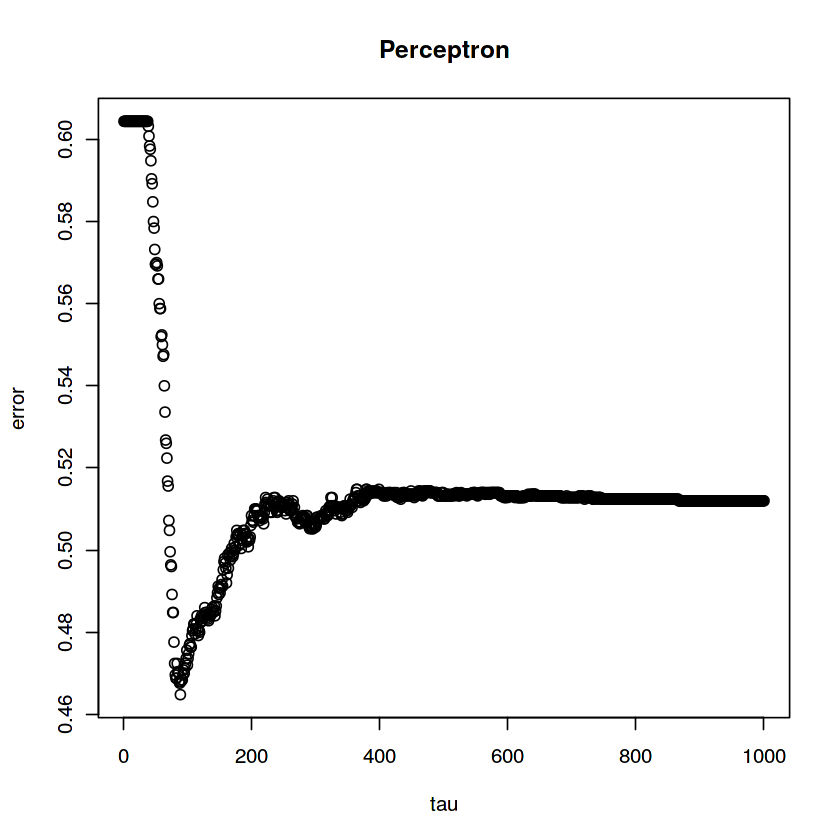

In [6]:
# Build a perceptron and plot its train error curve
W<-perceptron.build(X1, T1, tau.max = 1000, plotting = TRUE) # Run this a few times until you are happy with the result

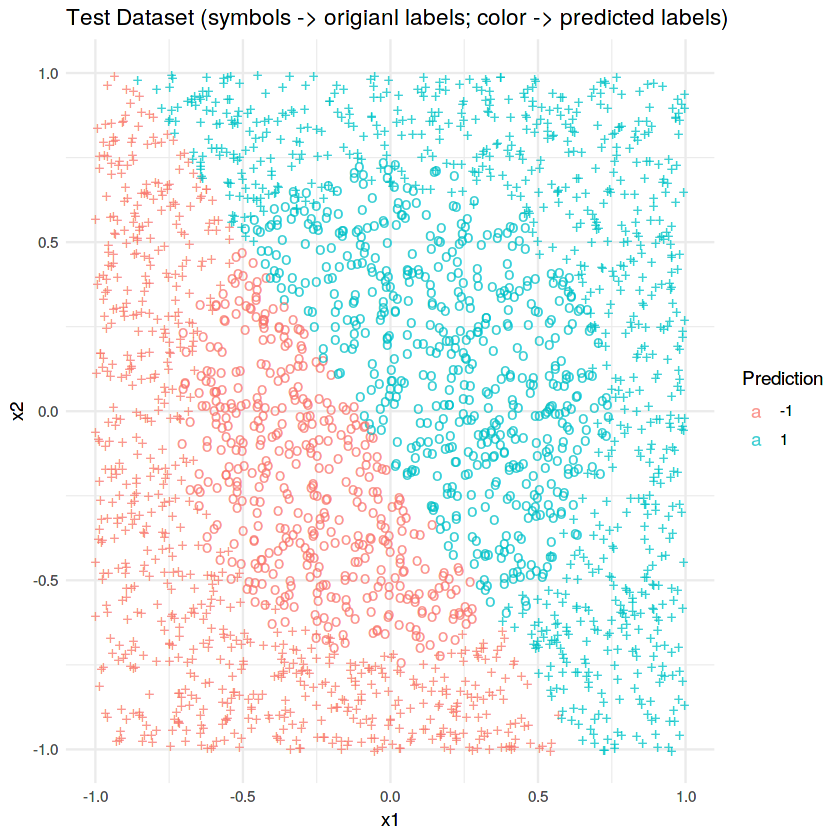

In [7]:
list[X2,T2] <- read.data('./Task2B_test.csv') # read test data
T2[T2==0] <- -1         # convert 0 labels to -1 
#? Evaluate Perceptron (TO BE COMPLETE)
## Hint: compute Phi, predict the test labels based on the model from the above statements, and then compare the predicted labels with the real labels
Phi.test <- as.matrix(cbind(1, X2)) # add a column of 1 as phi_0
pred.label <- ifelse(Phi.test%*%W > 0, +1, -1)

#? Plot Perceptron Decision Boundary (TO BE COMPLETE)
## Hint: Plot the testing data with different symbols for each class (real labels). Then color each point based on its predicted label.
# Visualizations
## Ploting the decision boundary
ggplot(data=X2, aes(x=x1, y=x2, label=ifelse(T2!=-1, '+', 'o'), color=factor(pred.label))) +
    geom_text(alpha=0.75) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction'))+
    ggtitle('Test Dataset (symbols -> origianl labels; color -> predicted labels)') +
    theme_minimal()

In [8]:
# Test error ratio
dim(X2[Phi.test%*%W*T2<0,])[1]/dim(X2)[1]

[1] 0.514

## 3. Neural Network

In [9]:
####################### NEURAL NET ####################### 
## the activation function (tanh here)
h <- function(z, a=1) { #activation function (sigmoid here)
  return ((exp(z)-a^(-z))/(exp(z)+exp(-z)))
}
## the derivitive of the activation function (tanh here)
h.d <- function(z, a=1) {
  return (1-(h(z, a))^2)
}
## Class Probabilities
class.prob <- function(X, W1, W2, b1, b2){
  a2 <- h(sweep(W1 %*% X, 1, b1,'+' ))
  a3 <- h(sweep(W2 %*% a2, 1, b2,'+' ))
  return (a3)
}
## prediction
nn.predict <- function(X, W1, W2, b1, b2, threshold=0.5){
  return (ifelse(class.prob(X, W1, W2, b1, b2)>=threshold, 1, -1))
}
## feedforward step
feedforward <- function(Xi, Ti, W1, b1, W2, b2){
  ### 1st (input) layer 
  a1 <- Xi
  y <- Ti
  ### 2nd (hidden) layer
  z2 <- W1 %*% a1 + b1
  a2 <- h(z2)        
  ### 3rd (output) layer
  z3 <- W2 %*% a2 + b2
  a3 <- h(z3)  
  return(list(a1, a2, a3, y, z2, z3))
}
## backpropagation step
backpropagation <- function(Ti, W2, z2, z3, a3){
  ### 3rd (output) layer
  d3 <- -(Ti-a3) * h.d(z3)
  ### 2nd (hidden) layer
  d2 <-  t(W2)%*%d3  * h.d (z2)
  return(list(d2,d3))
}
## NN build function
nn.build <- function(K, X1, T1, plotting=FALSE, epoch.max=50, eta = 0.1, lambda = 0.01){
  # initialization
  if (plotting) {error.rec <- matrix(NA,nrow=epoch.max, ncol=1)}
  D <- nrow(X1)
  if (D!=2) {stop('nn.predict: This simple version only accepts two dimensional data.')}
  N <- ncol(X1)

  W1 <- matrix(rnorm(D*K, sd=0.5), nrow=K, ncol=D)
  b1 <- matrix(rnorm(1*K), nrow=K, ncol=1)
  W2 <- matrix(rnorm(K*1, sd=0.5), nrow=1, ncol=K)
  b2 <- matrix(rnorm(1*1), nrow=1, ncol=1)

  for (epoch in 1:epoch.max){   
    ## delta vectors/matrices initialization
    W1.d <- W1 *0
    b1.d <- b1 *0
    W2.d <- W2 *0
    b2.d <- b2 *0

    for (i in 1:N){
      ## Feedforward:
      list[a1, a2, a3, y, z2, z3] <- feedforward(X1[,i], T1[i], W1, b1, W2, b2)          
      ## Backpropagation:
      list[d2, d3] <- backpropagation(T1[i], W2, z2, z3, a3)
      ## calculate the delta values
      ### 1st layer
      W1.d <- W1.d + d2 %*% t(a1)
      b1.d <- b1.d + d2
      ### 2nd layer
      W2.d <- W2.d + d3 %*% t(a2)
      b2.d <- b2.d + d3
    }
    ## update weight vectors and matrices
    W1 <- W1 - eta * (W1.d/N + lambda*W1)
    b1 <- b1 - eta * (b1.d/N)
    W2 <- W2 - eta * (W2.d/N + lambda*W2)
    b2 <- b2 - eta * (b2.d/N)
    ## record the errors
    if (plotting){error.rec[epoch]<- error.rate(nn.predict(X1, W1, W2, b1, b2), T1)}
  }
  plot(error.rec, xlab = 'epoch', ylab = 'error', main = 'Neural Net')
  
  return(list(W1, W2, b1, b2))
}

In [10]:
seq.vec <- seq(2, 100, 2)
result <- data.frame('K'= rep(seq.vec, each = 1),'test.error'=rep(0,length(seq.vec)))

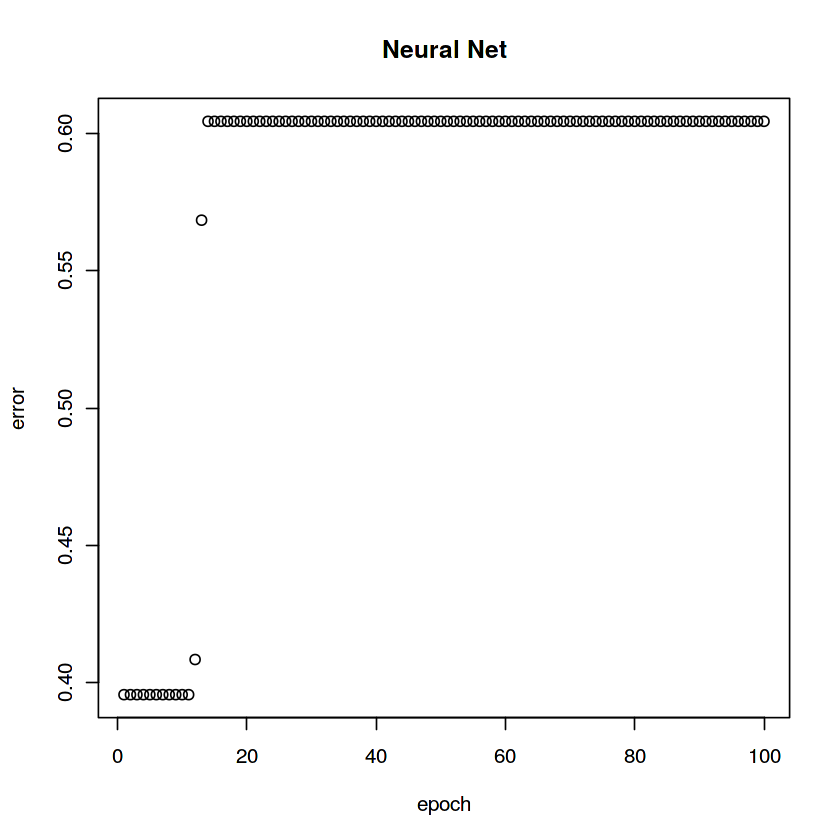

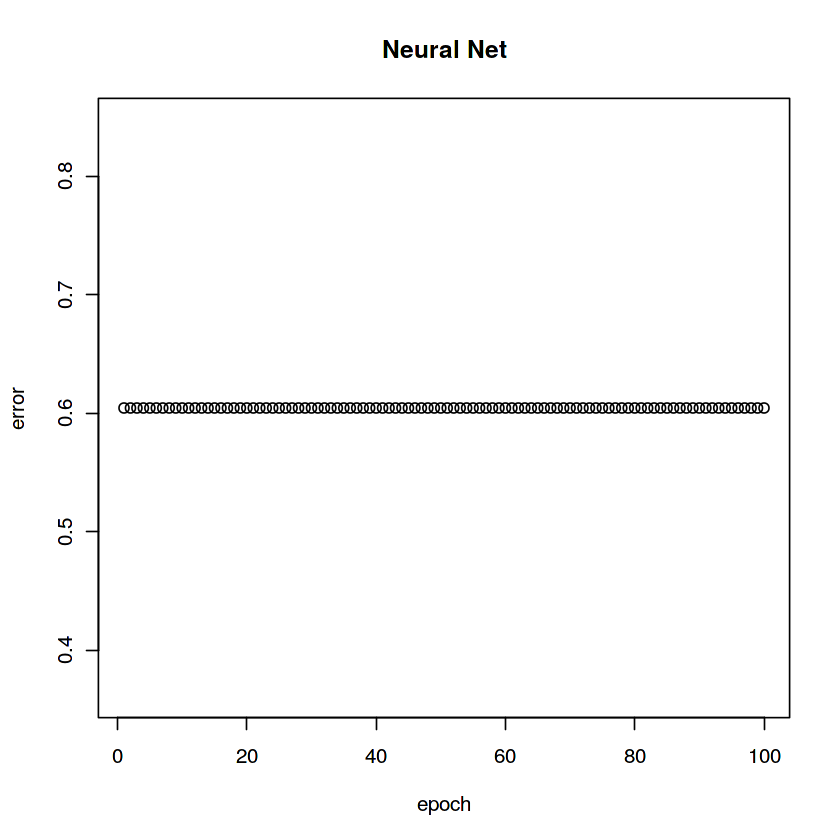

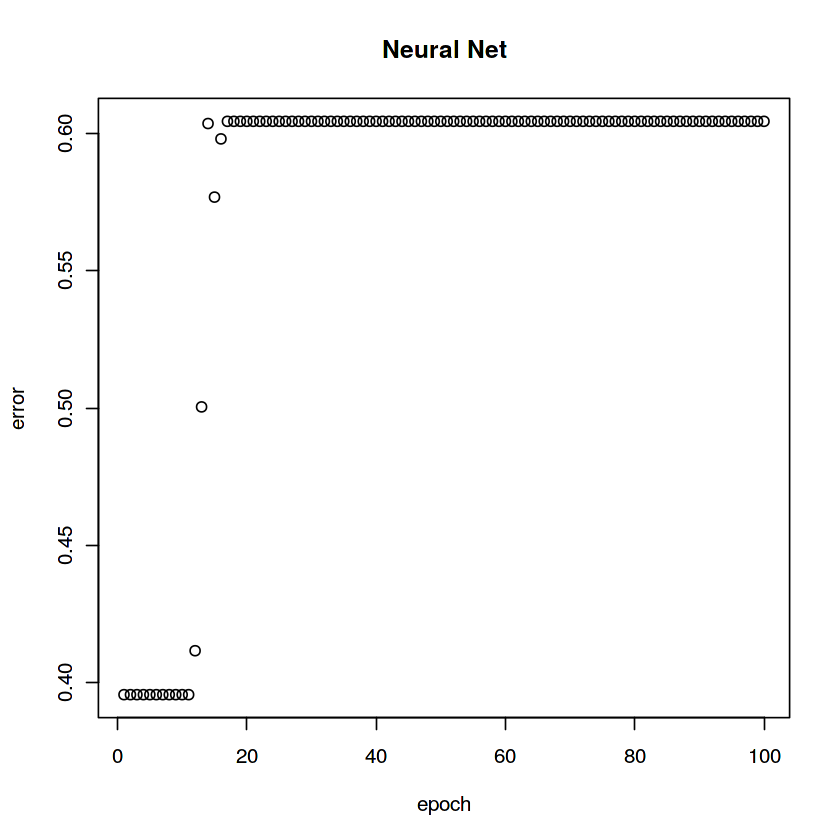

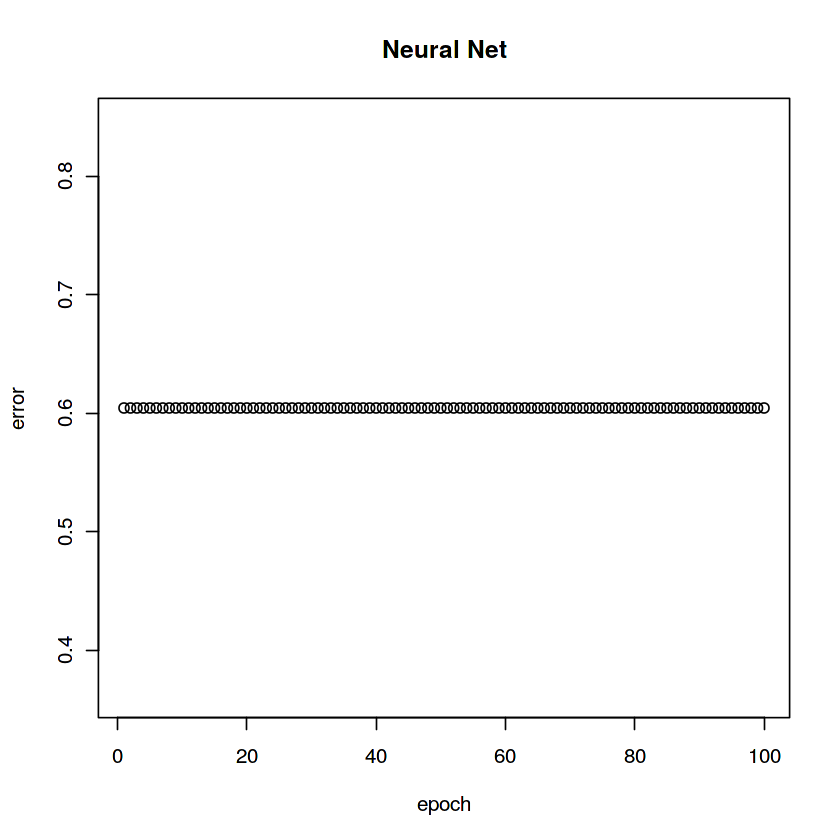

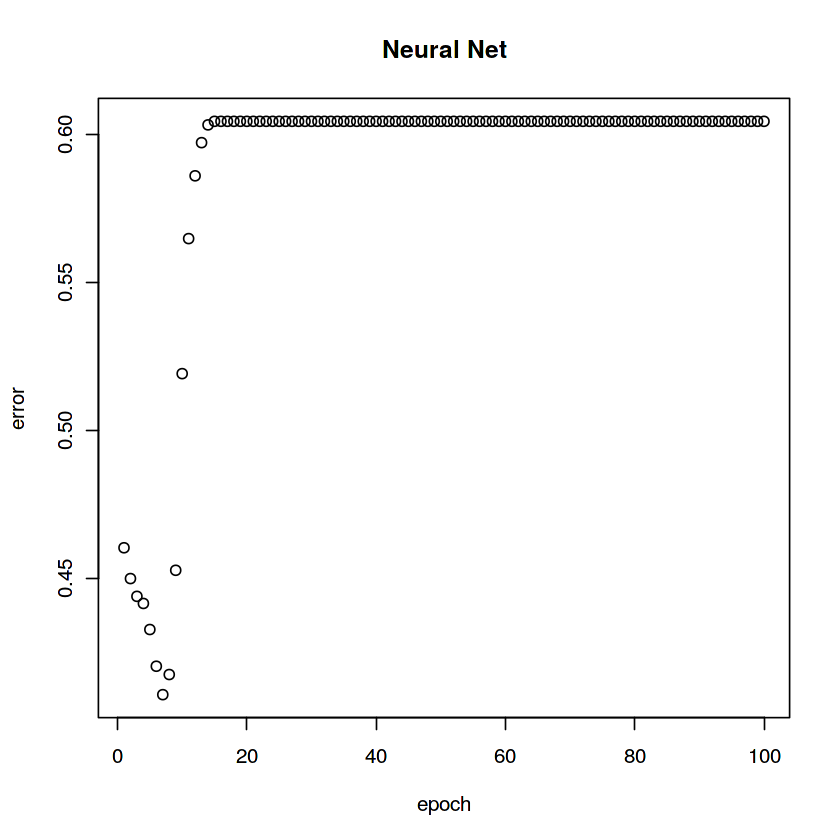

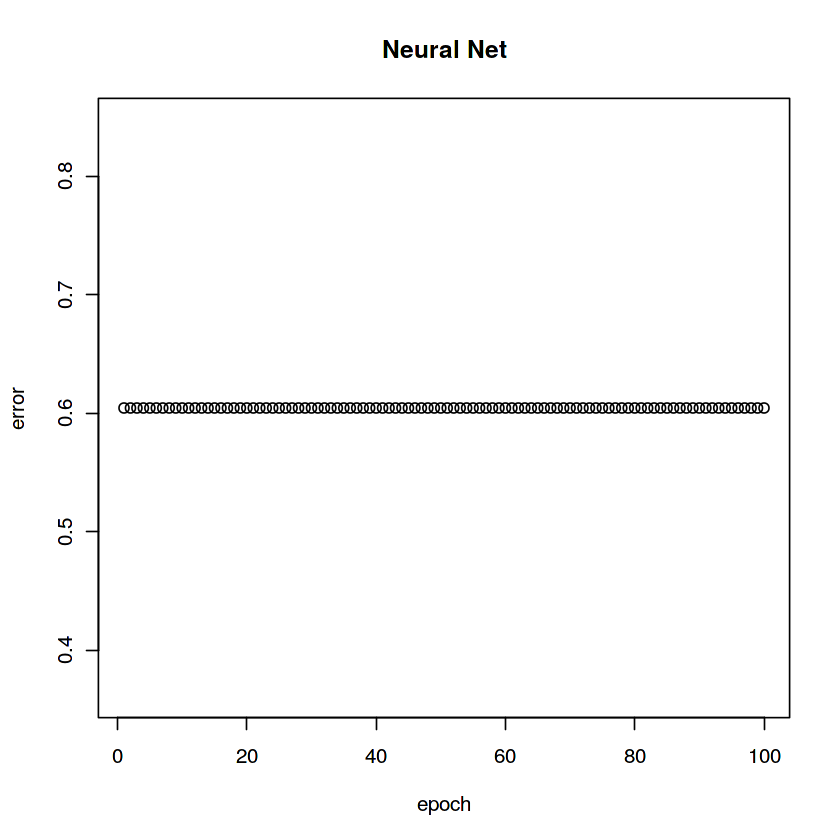

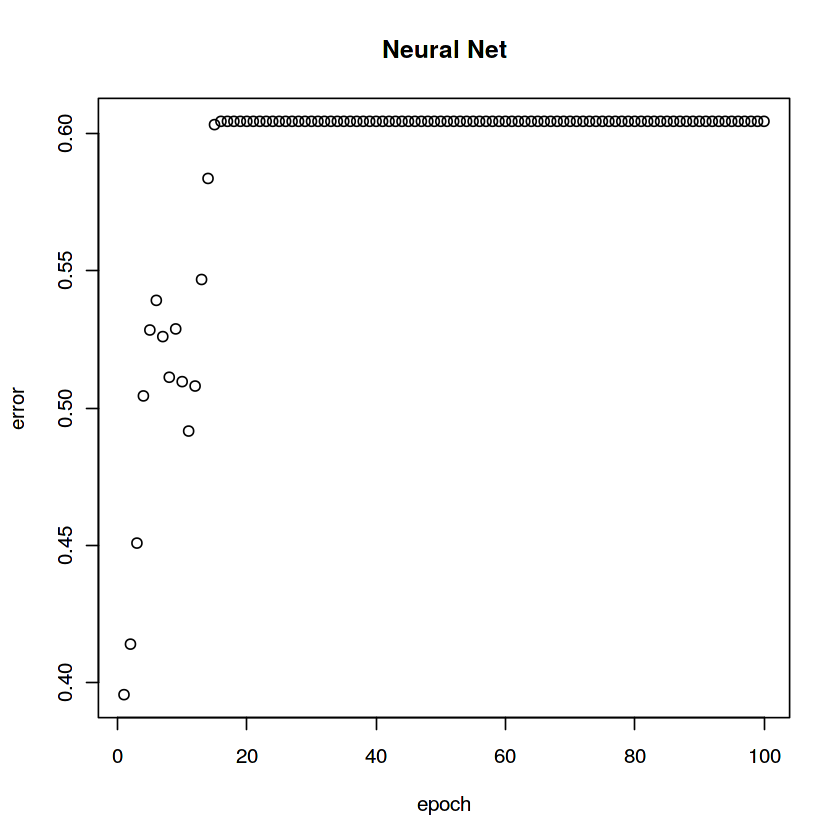

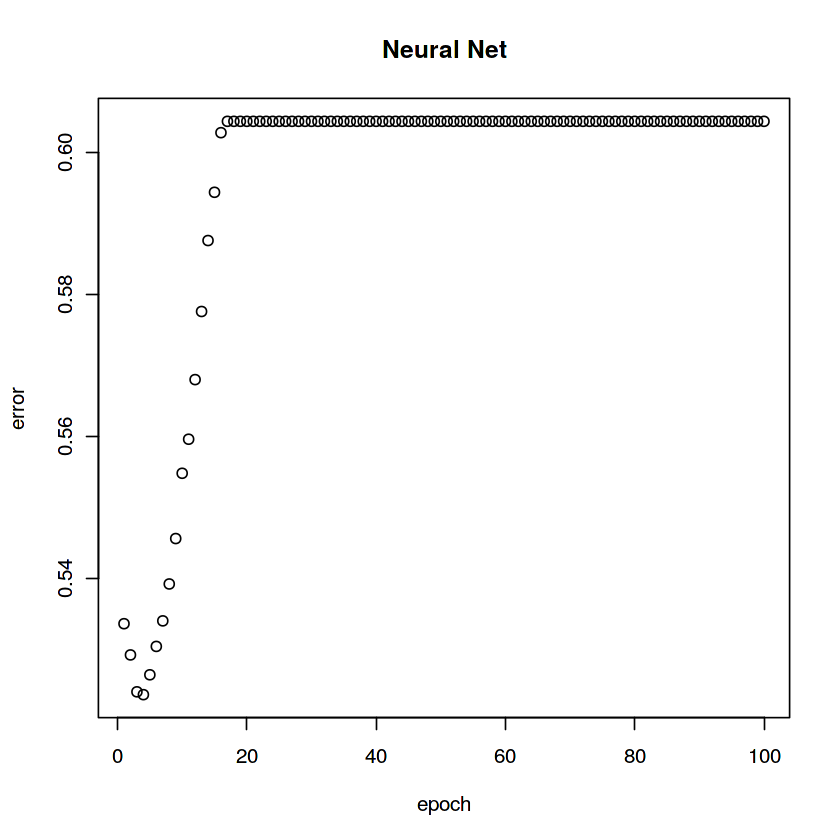

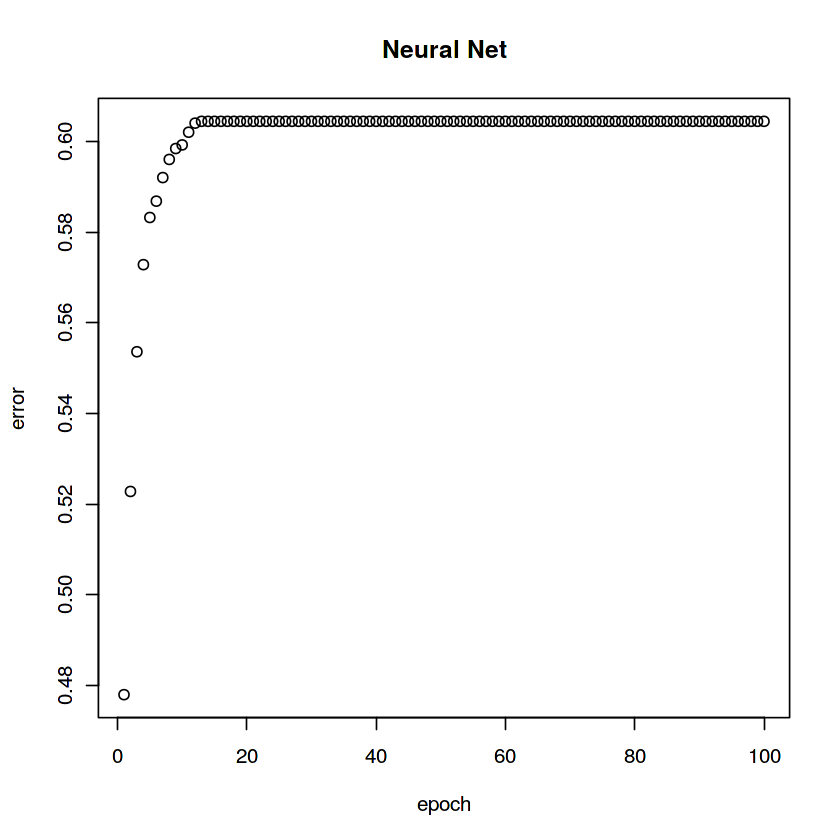

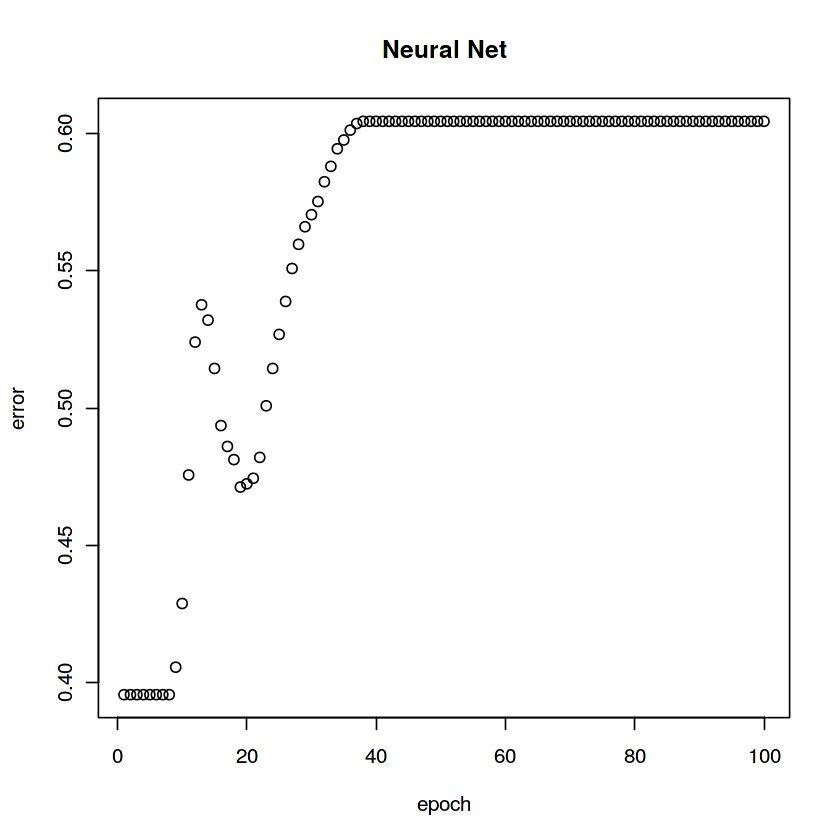

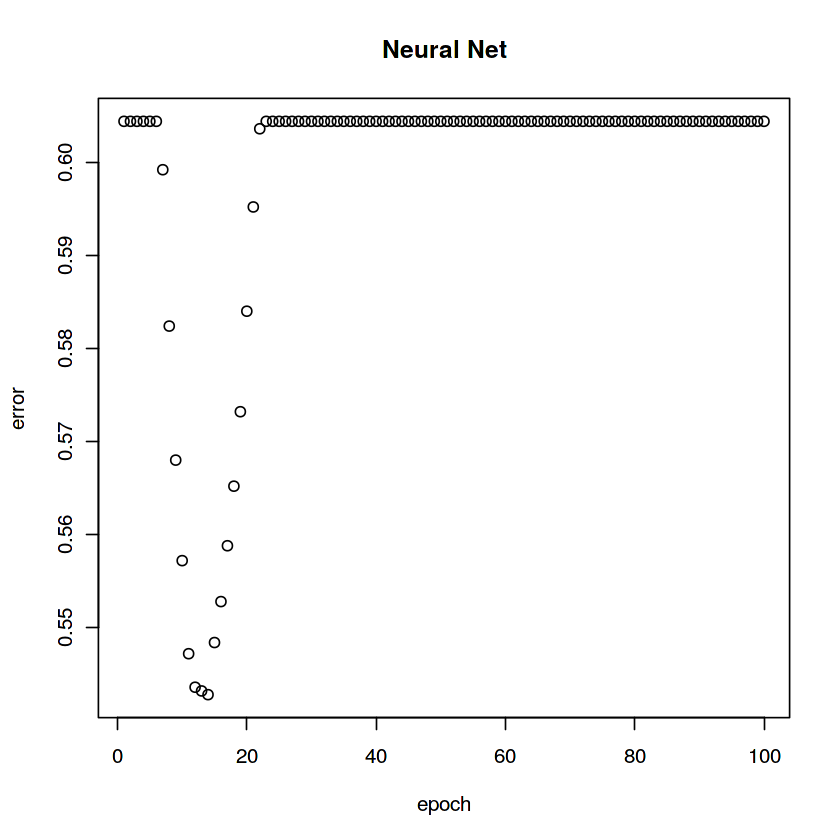

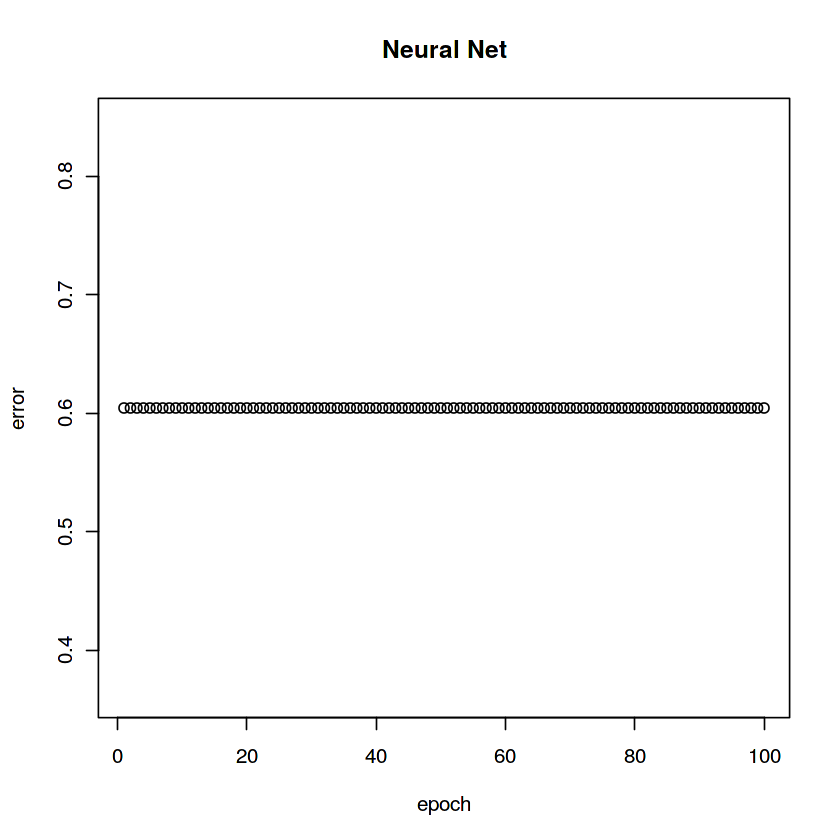

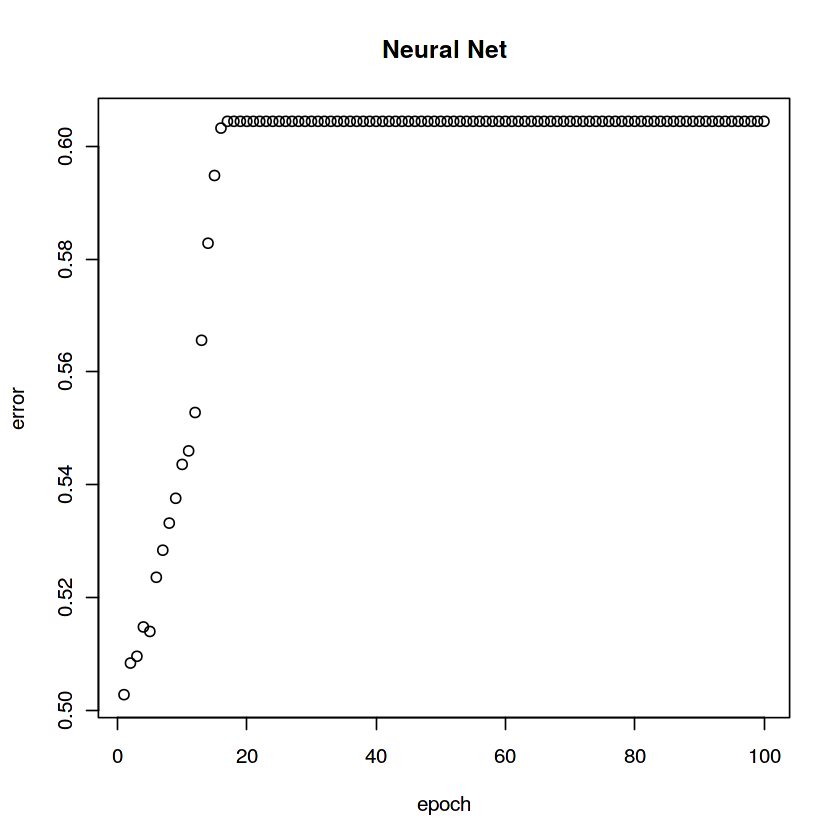

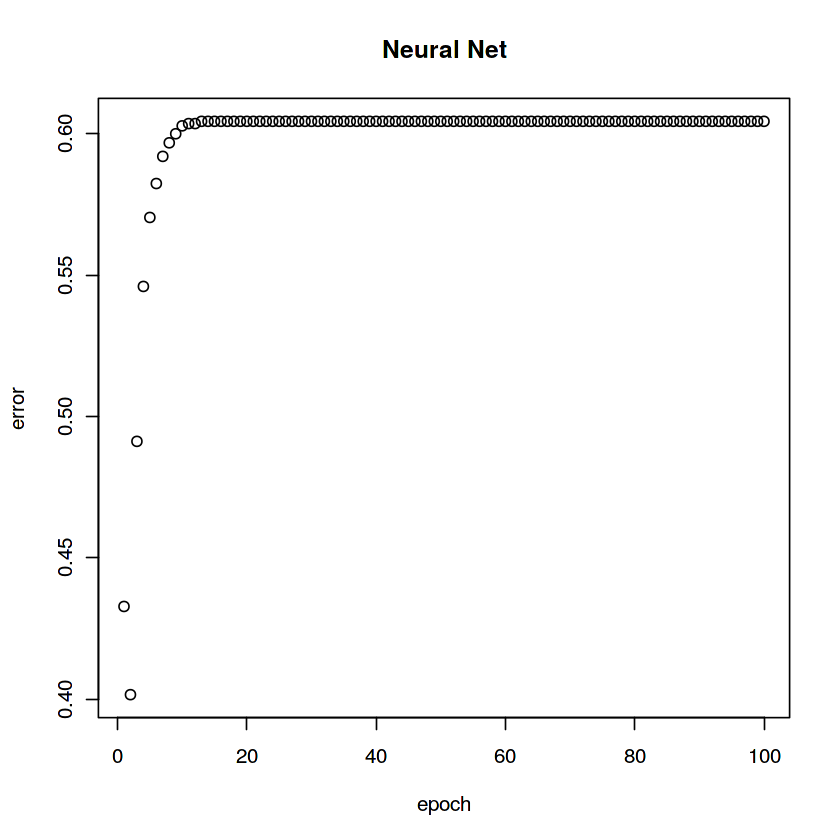

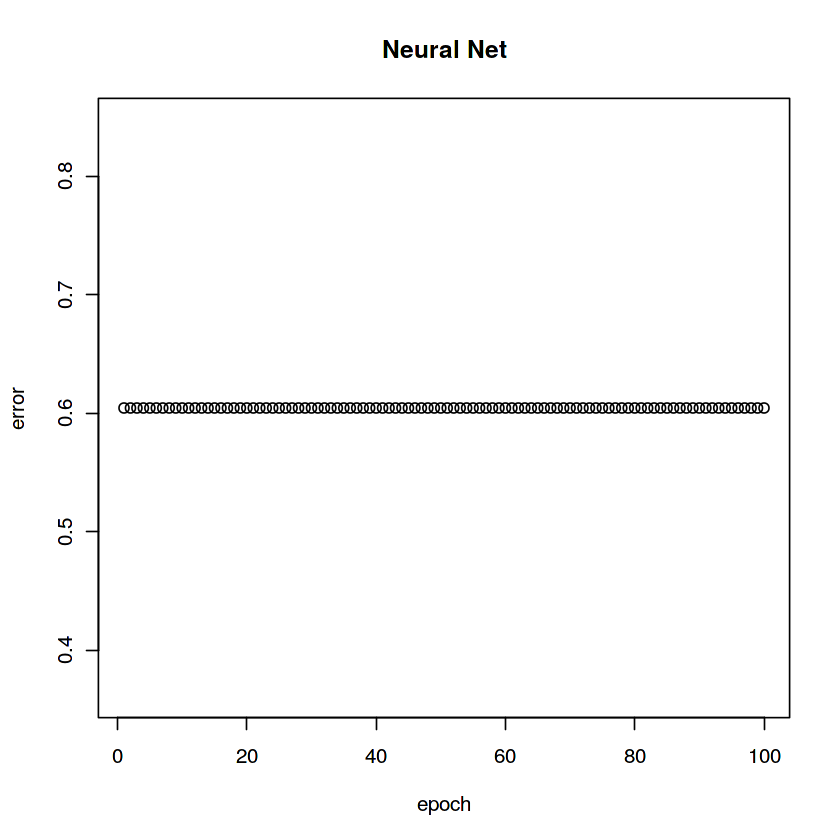

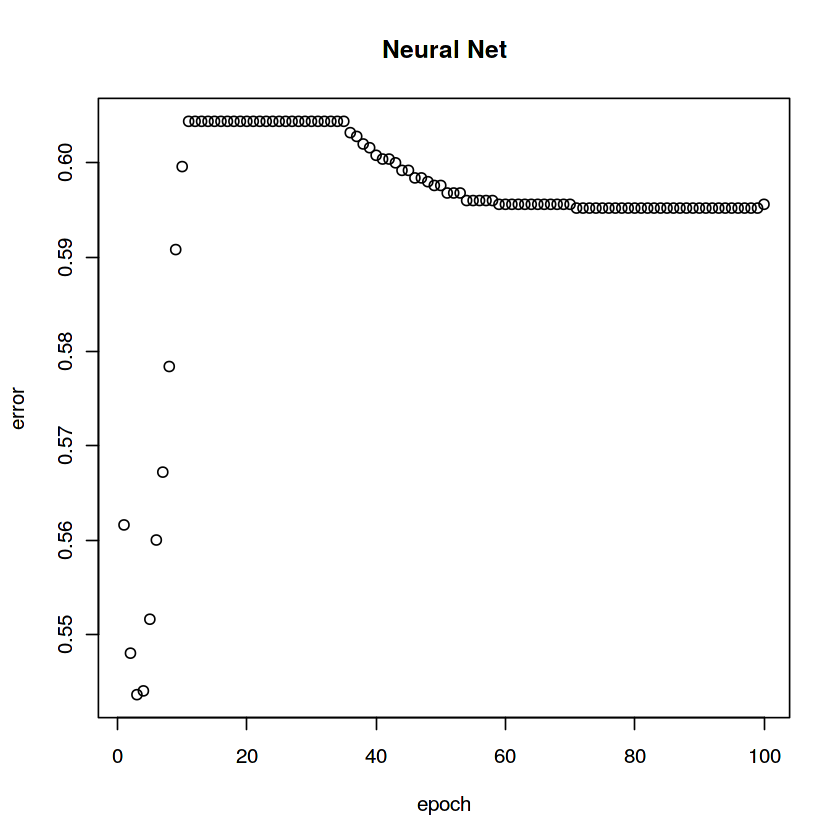

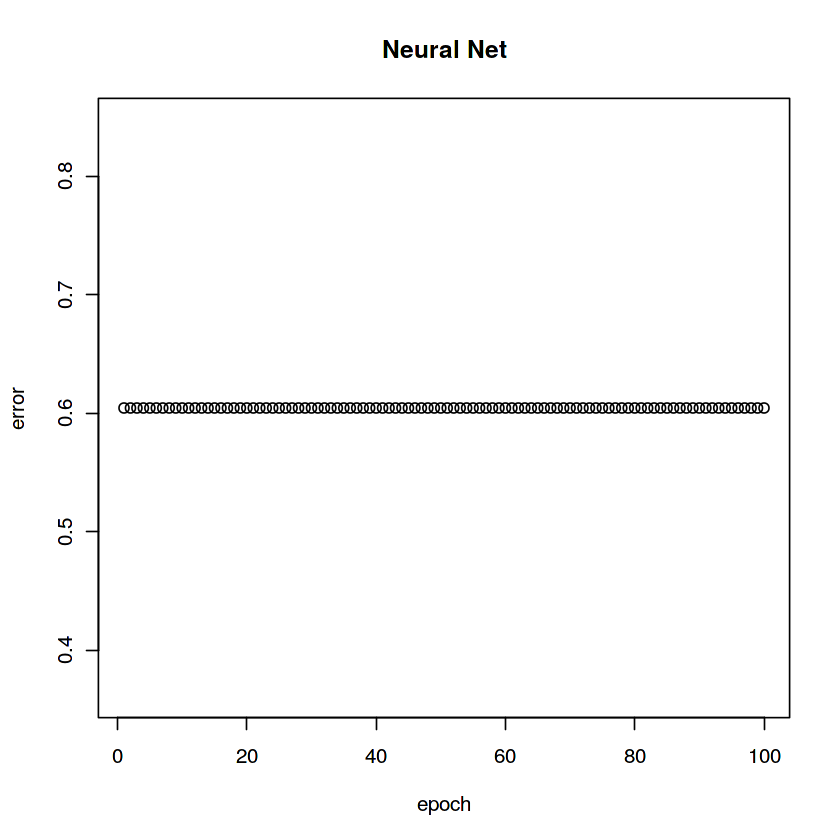

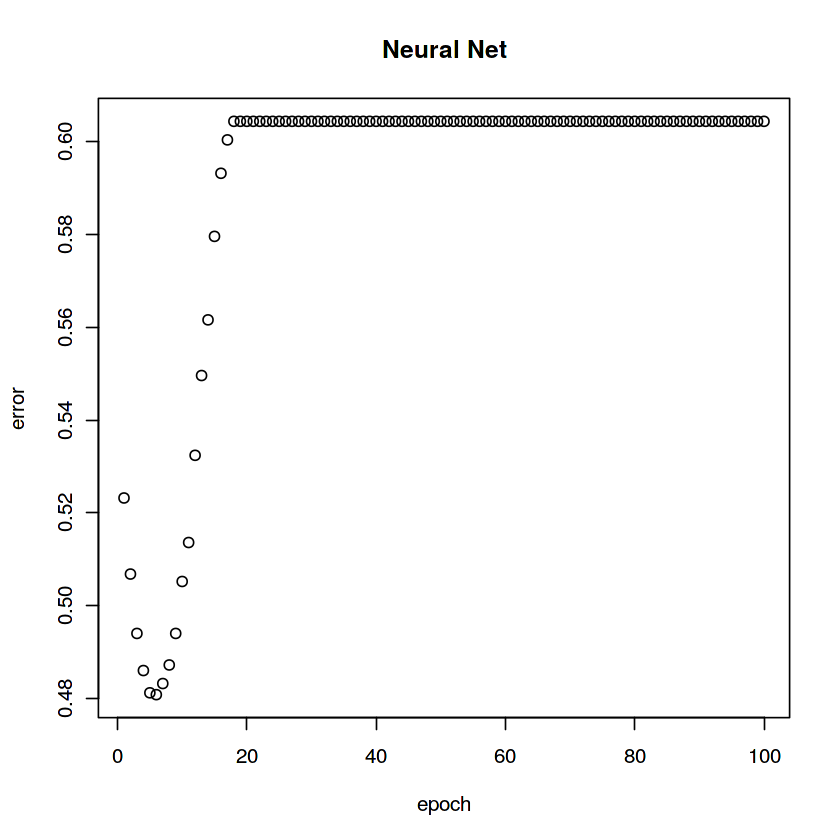

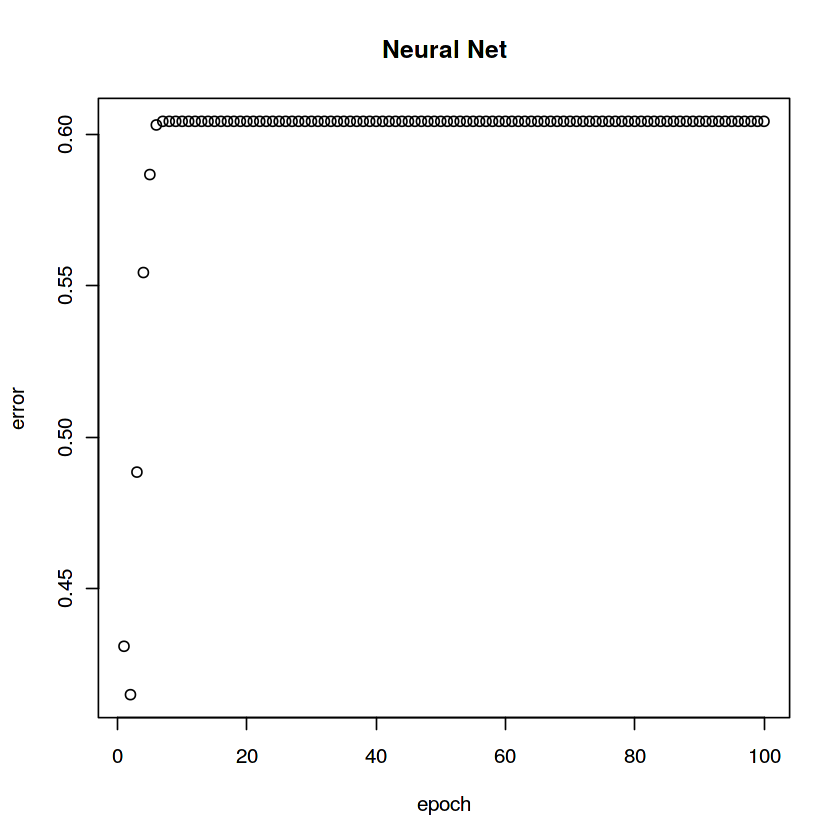

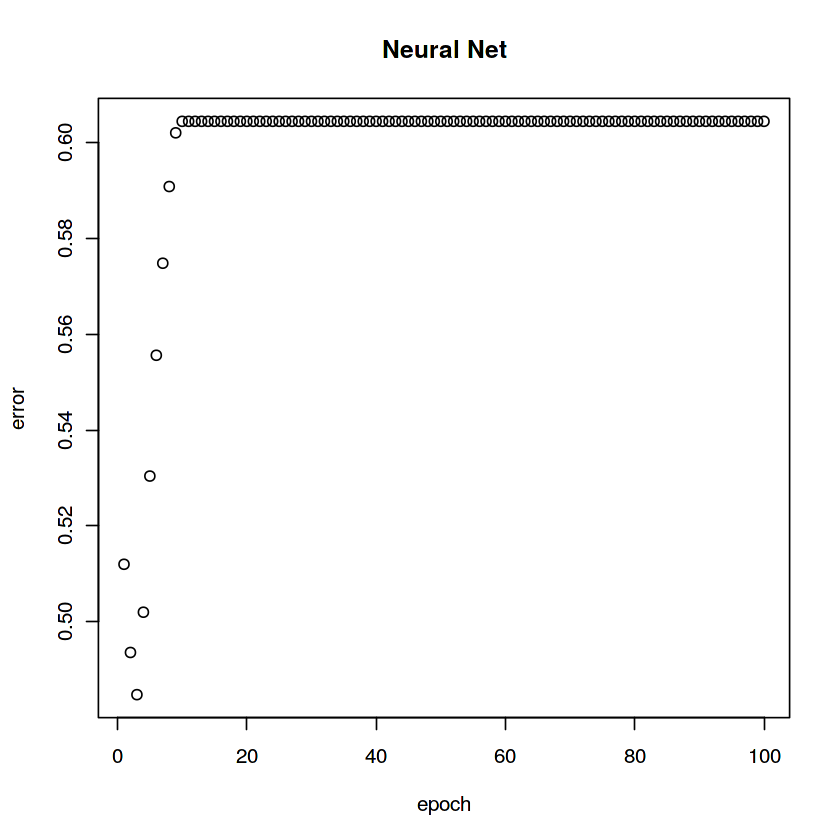

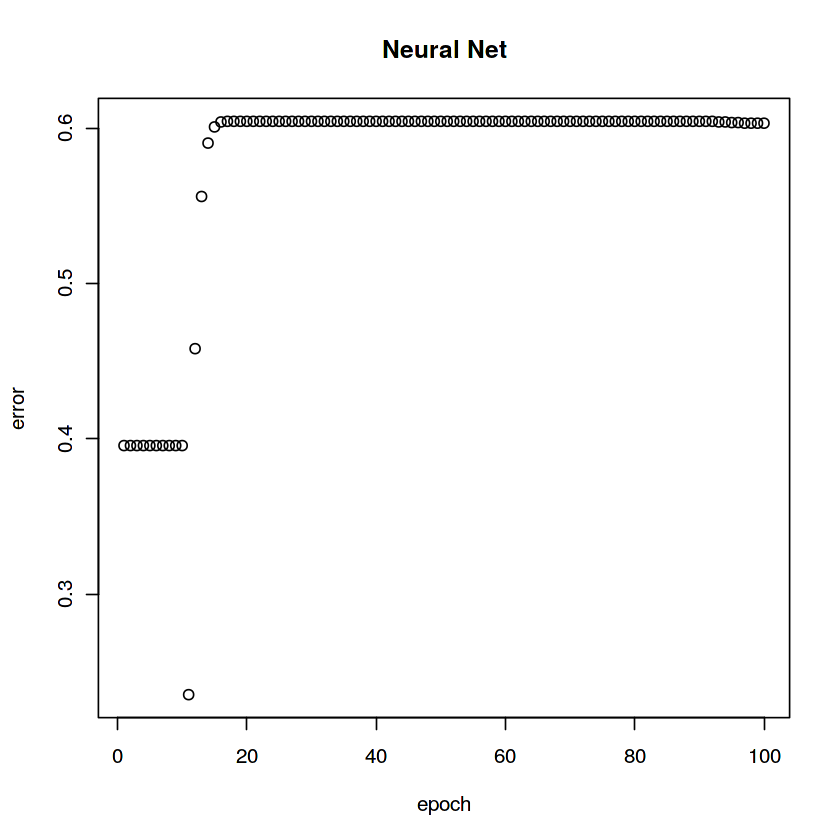

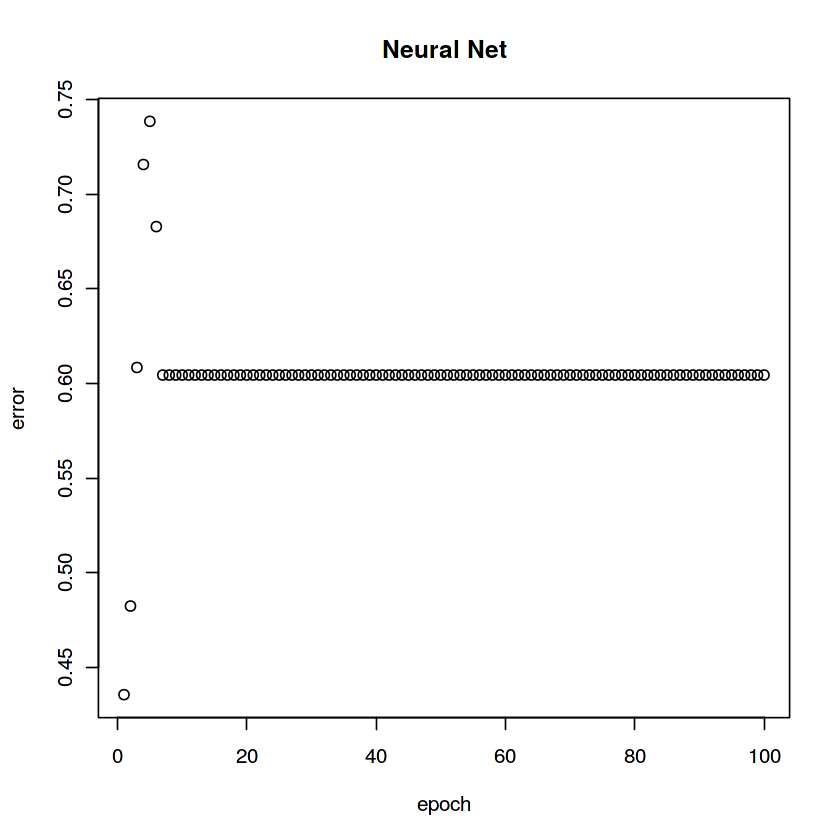

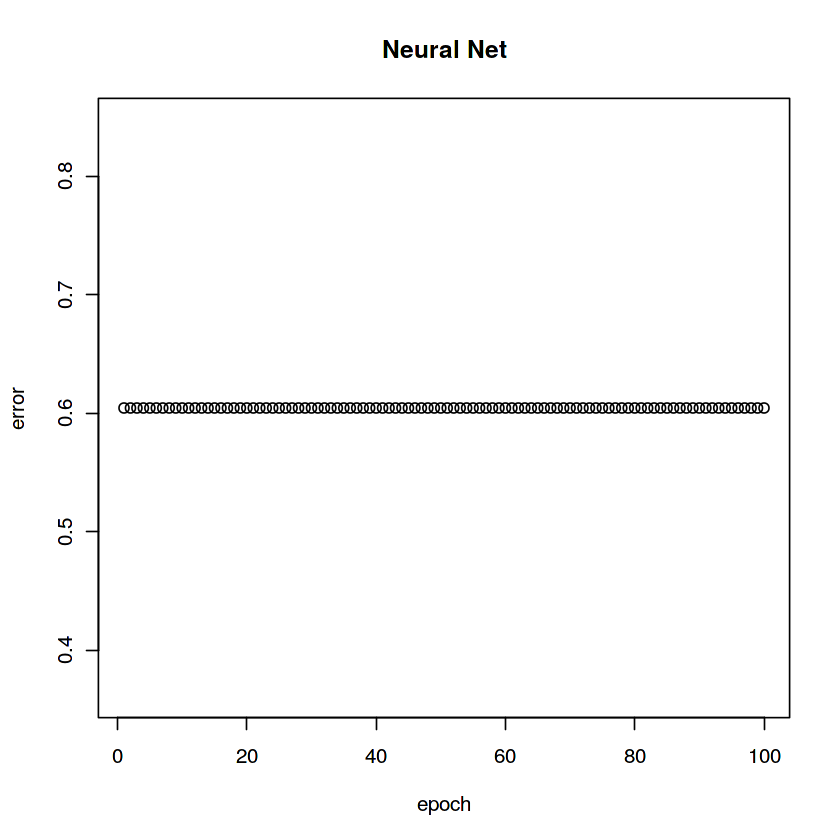

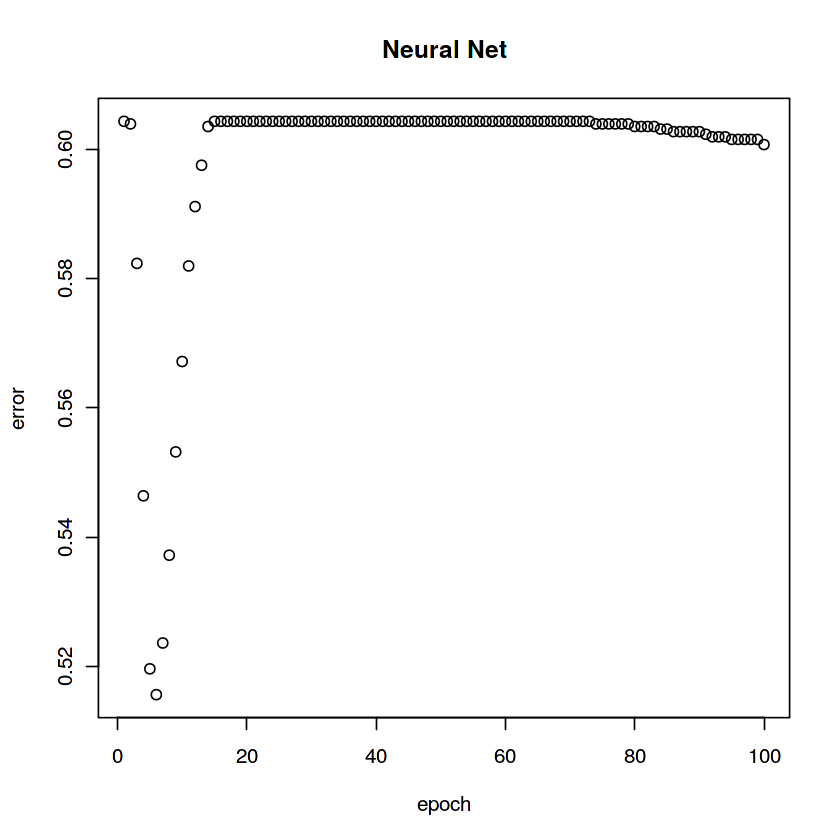

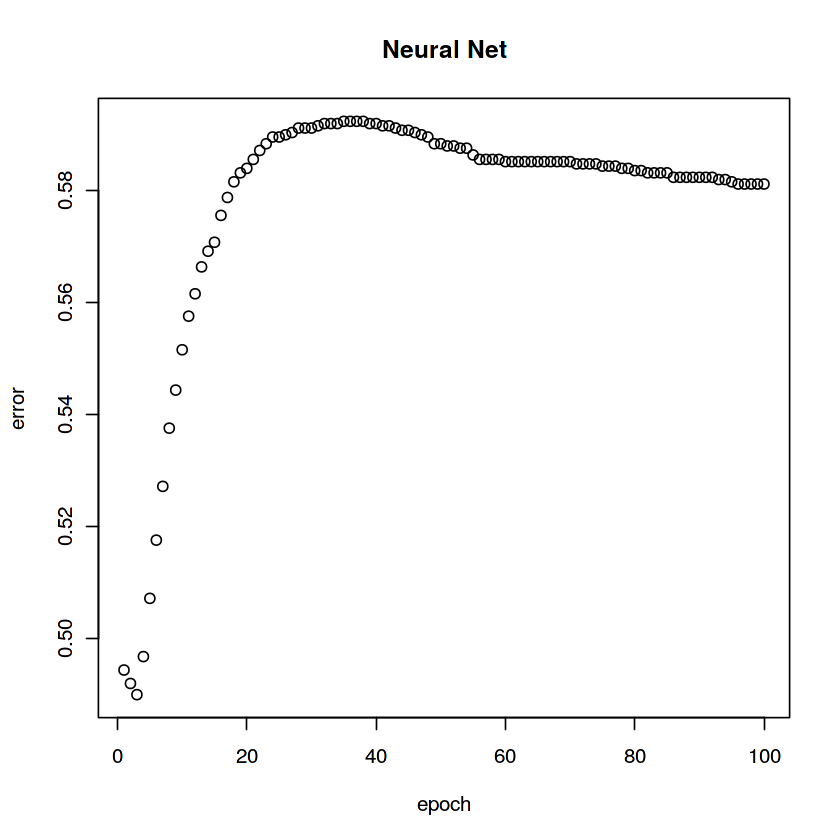

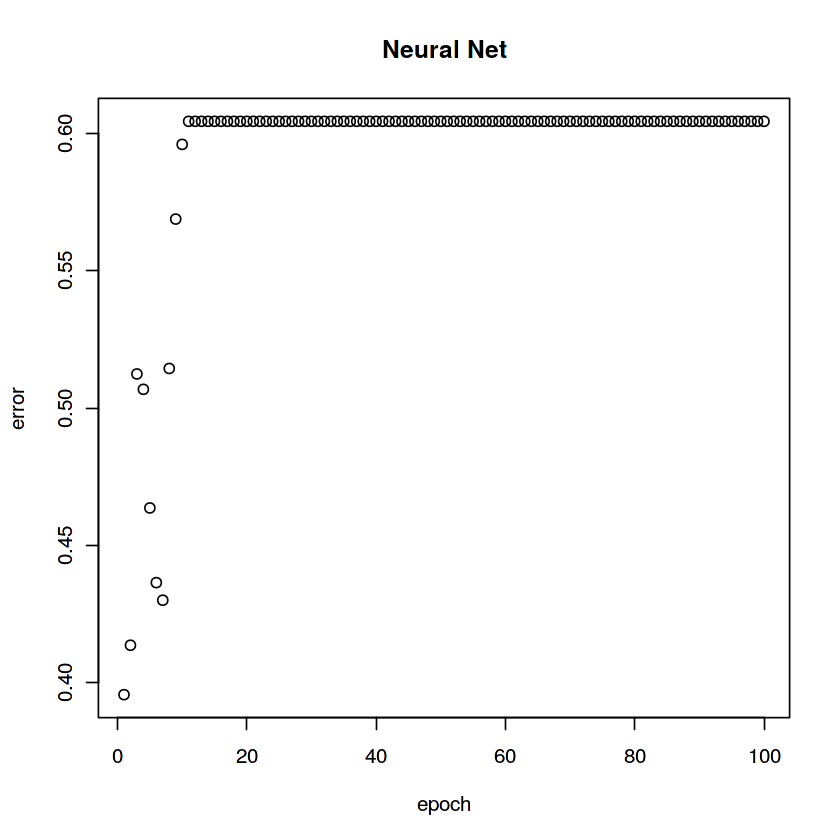

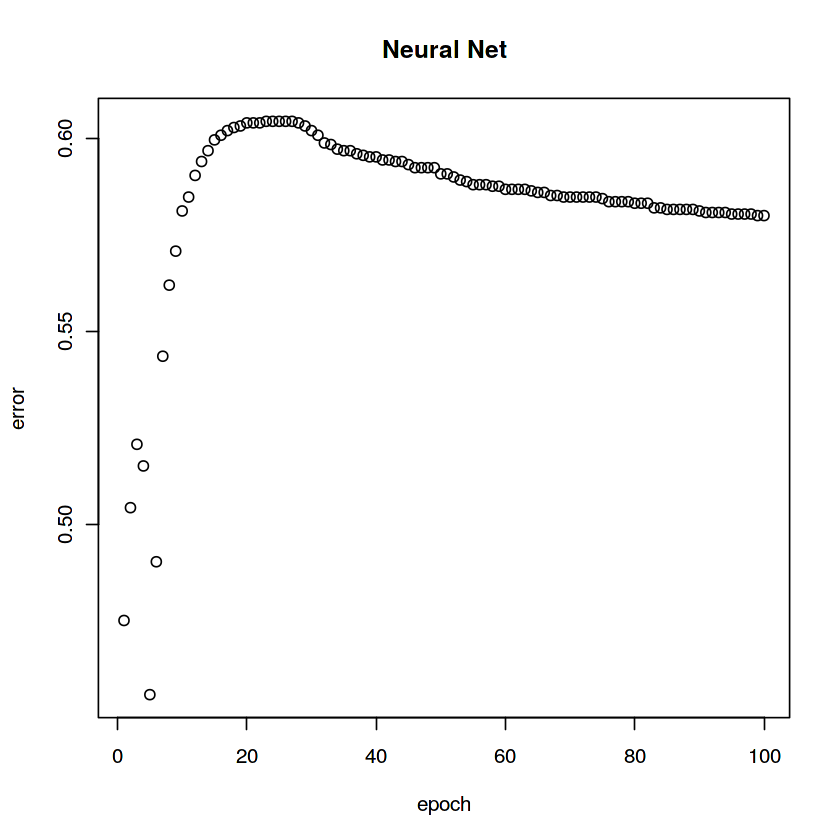

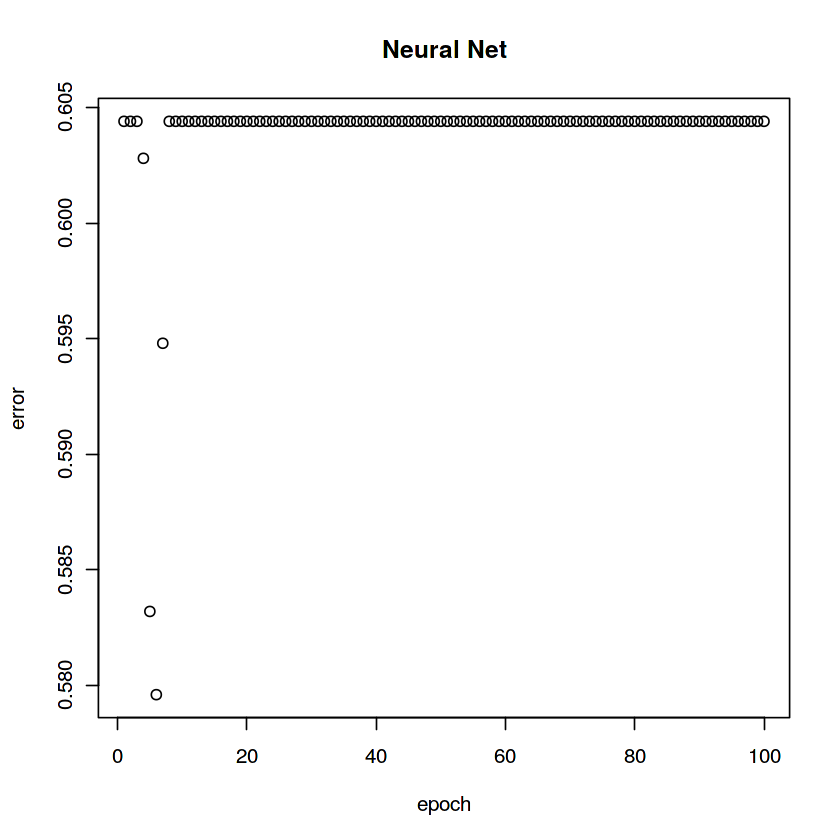

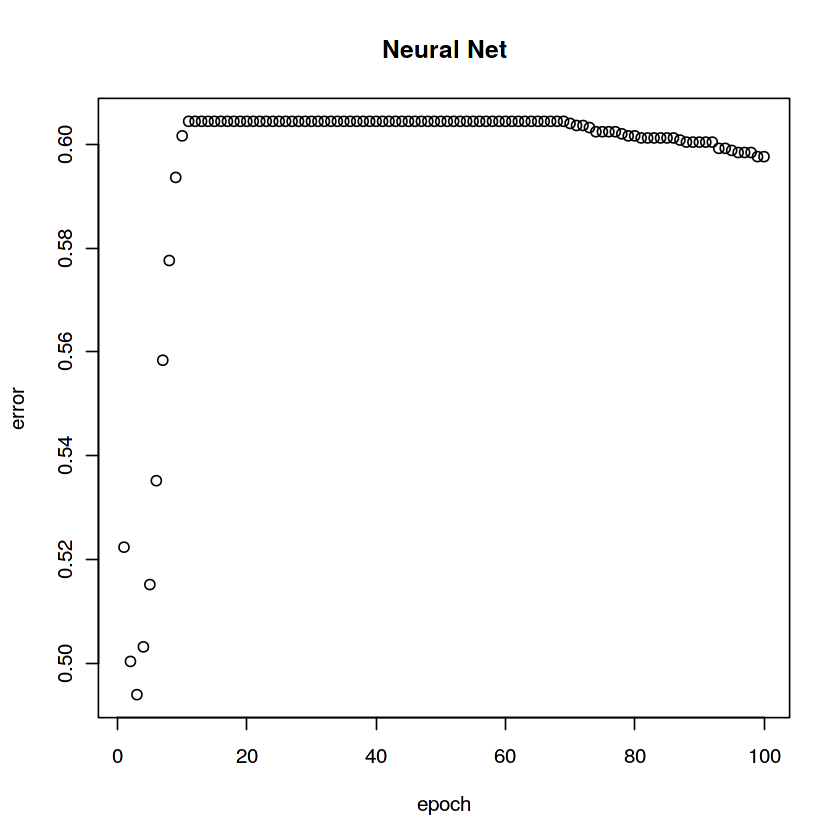

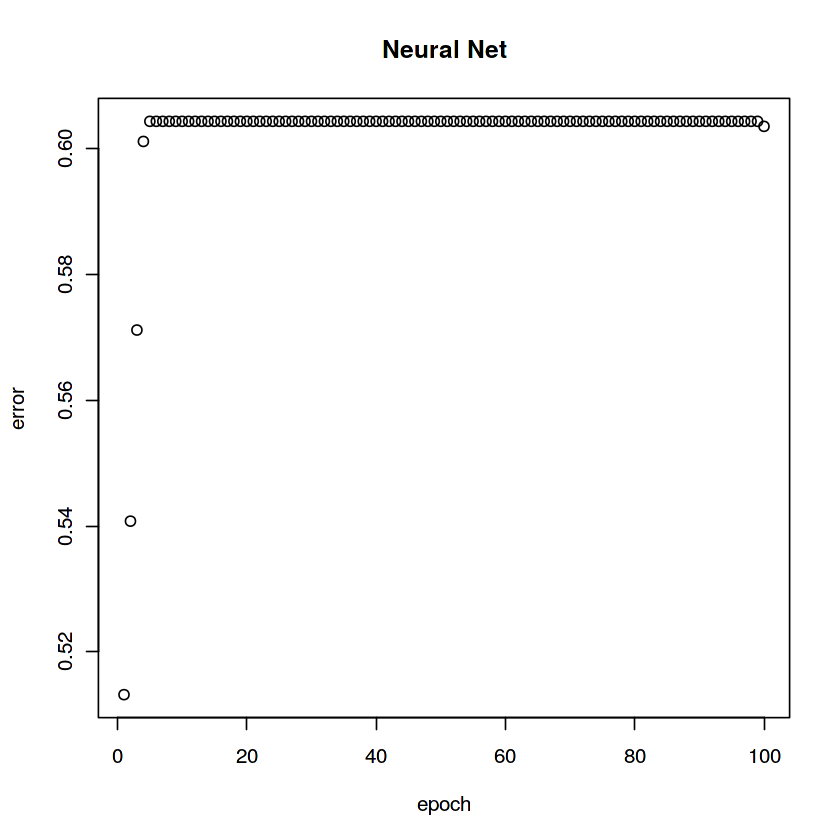

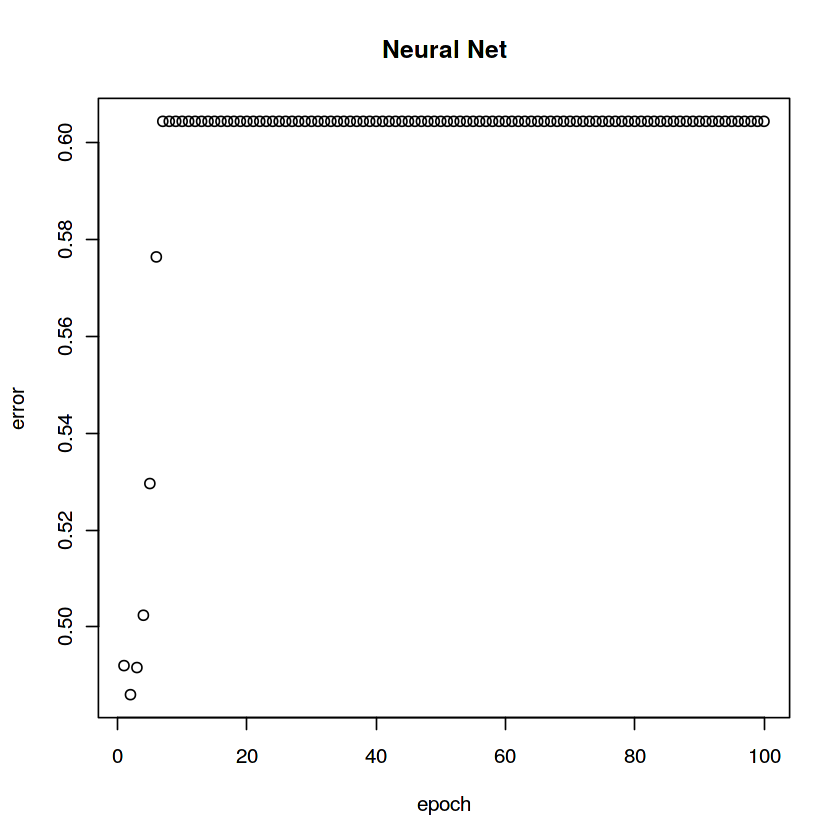

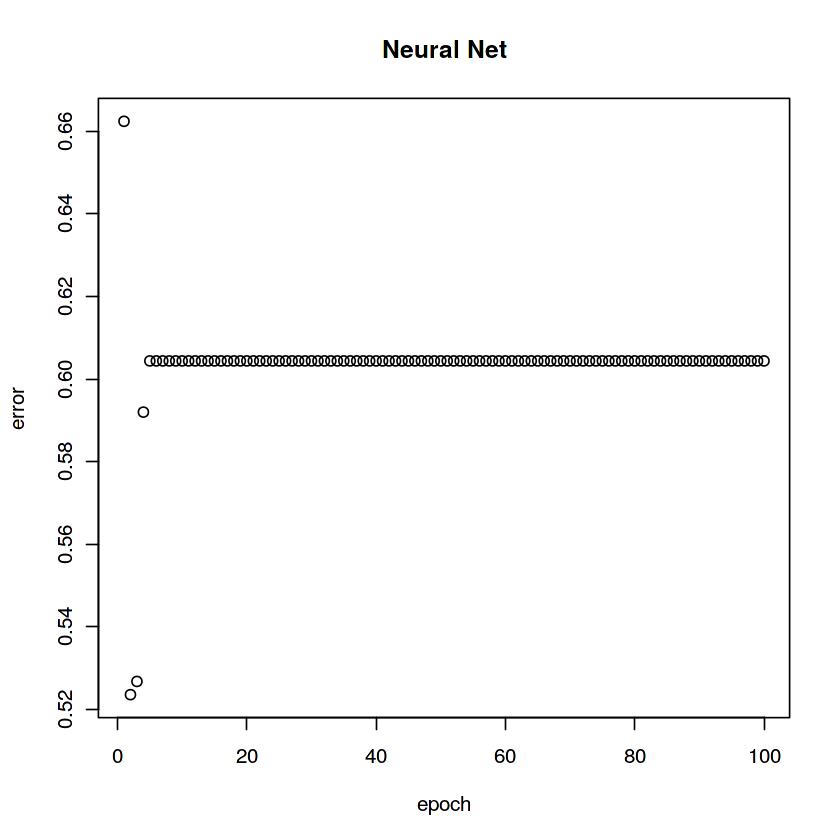

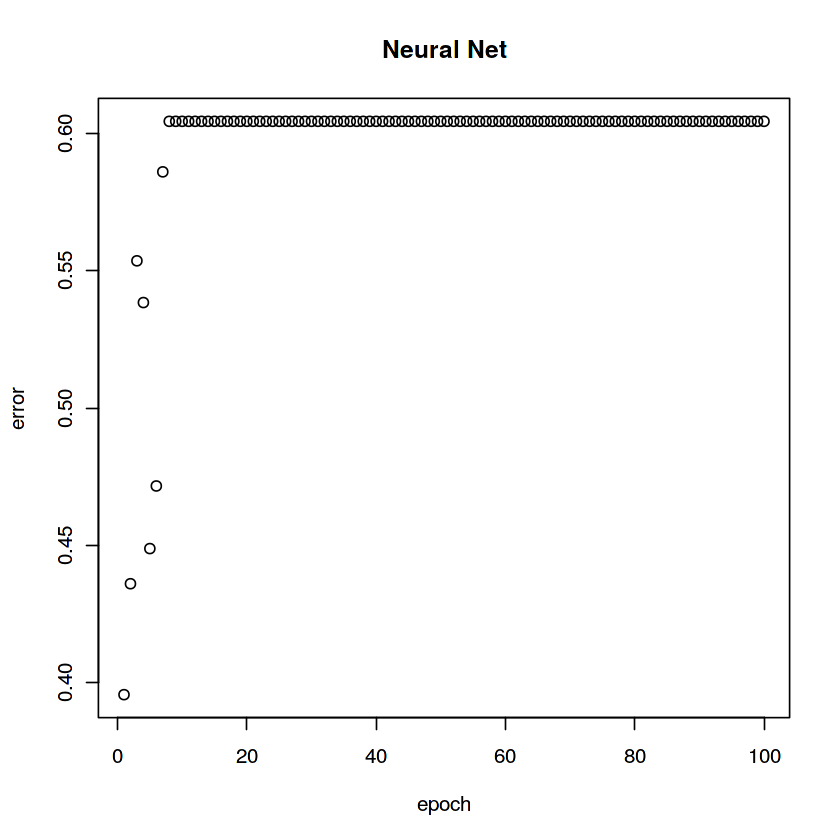

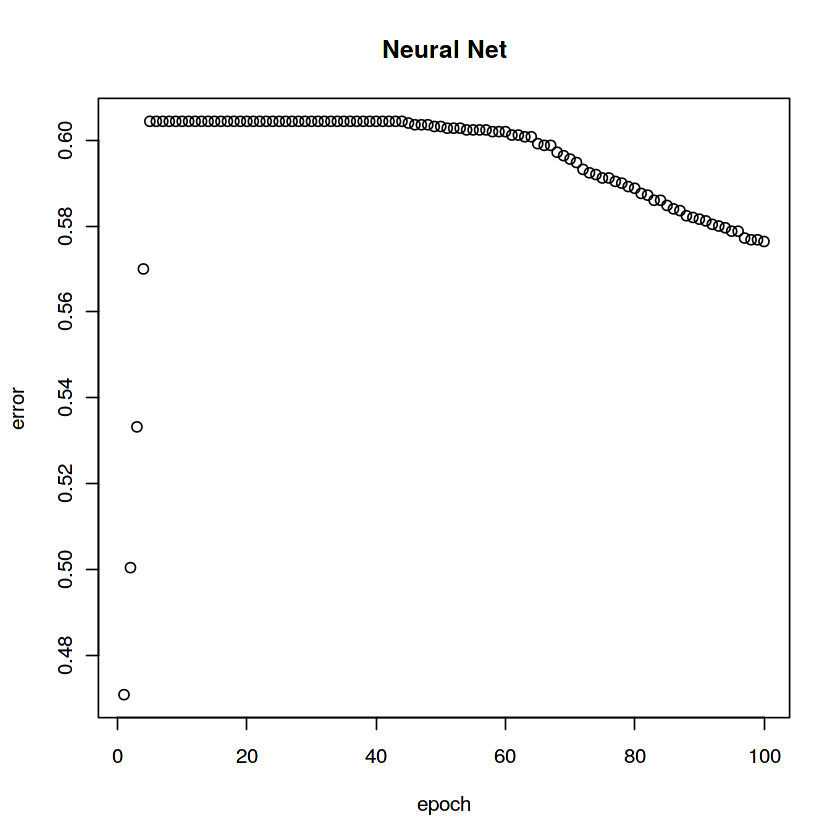

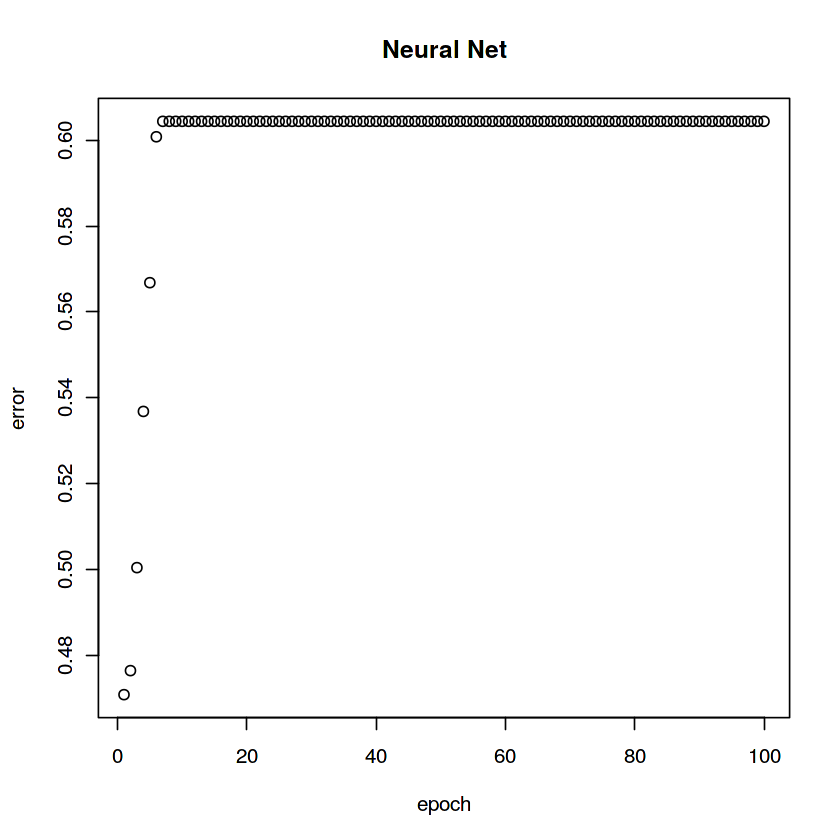

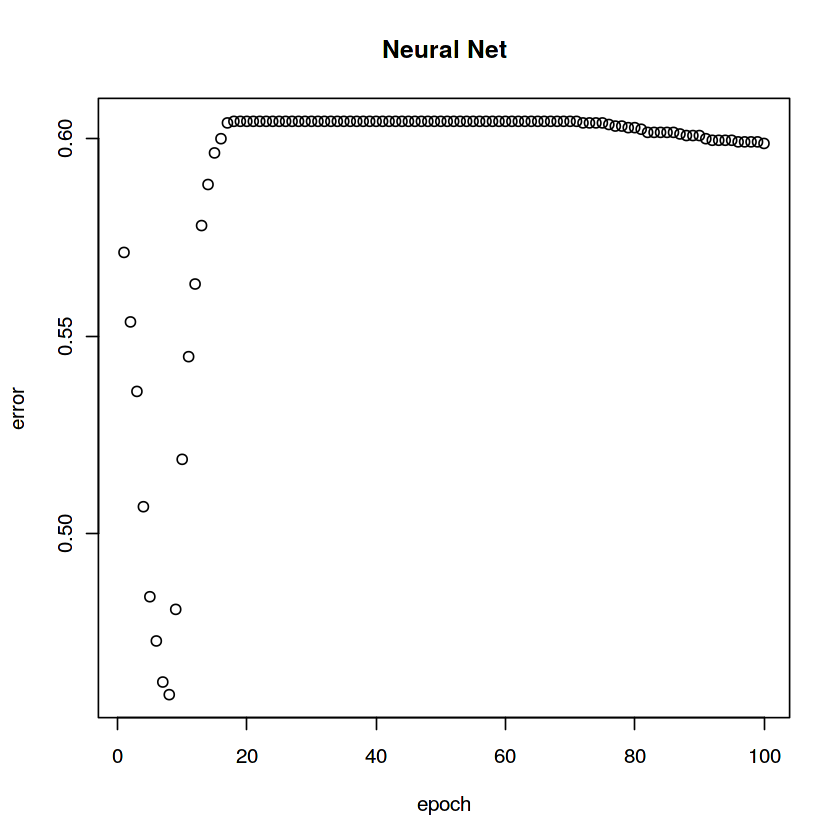

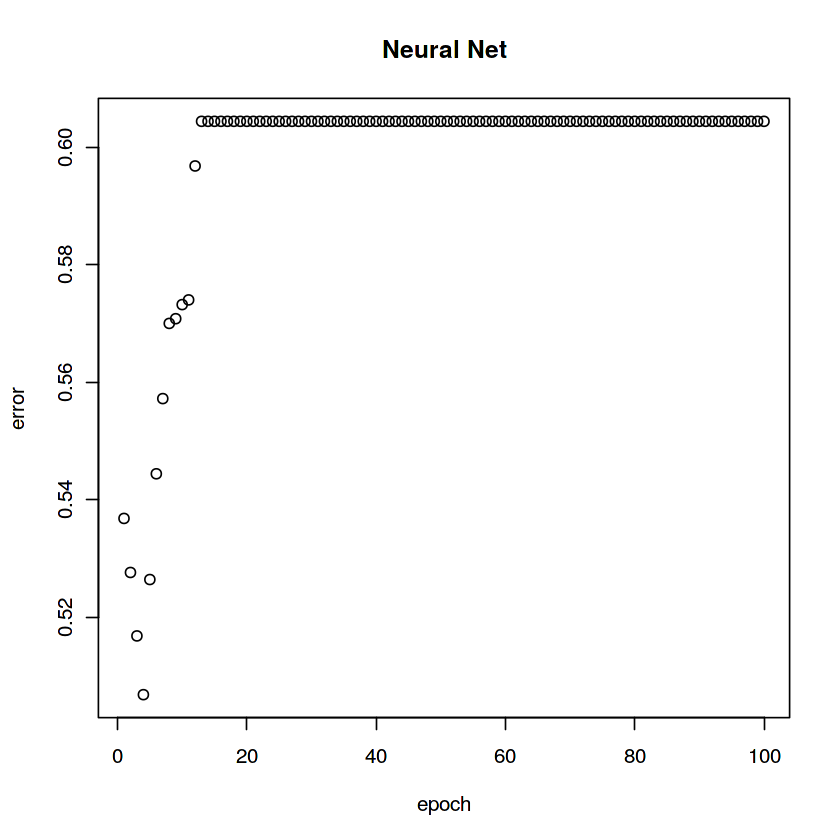

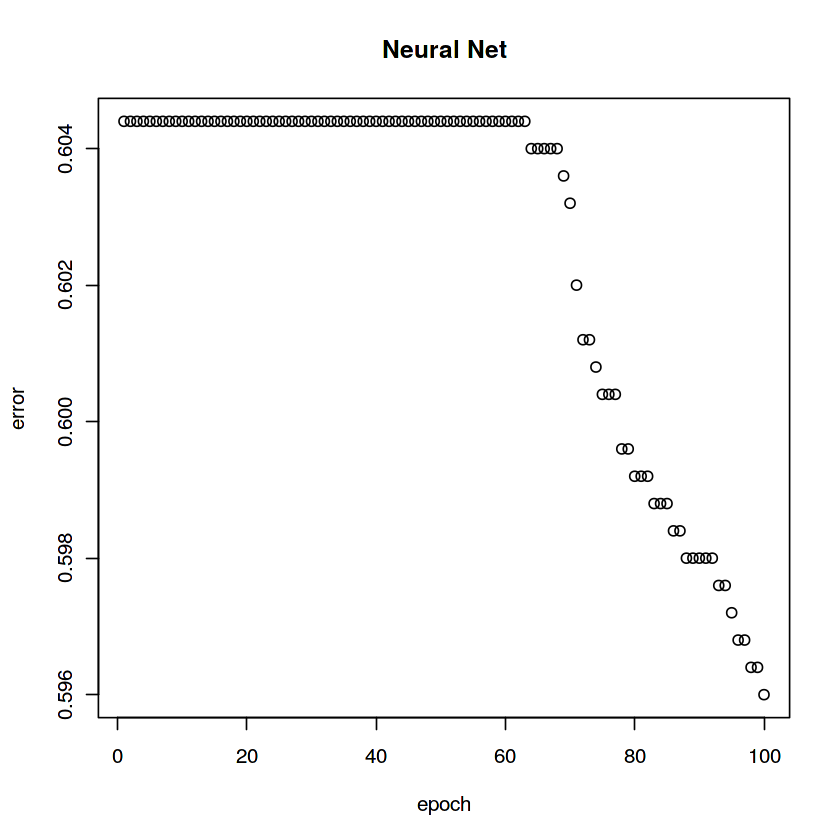

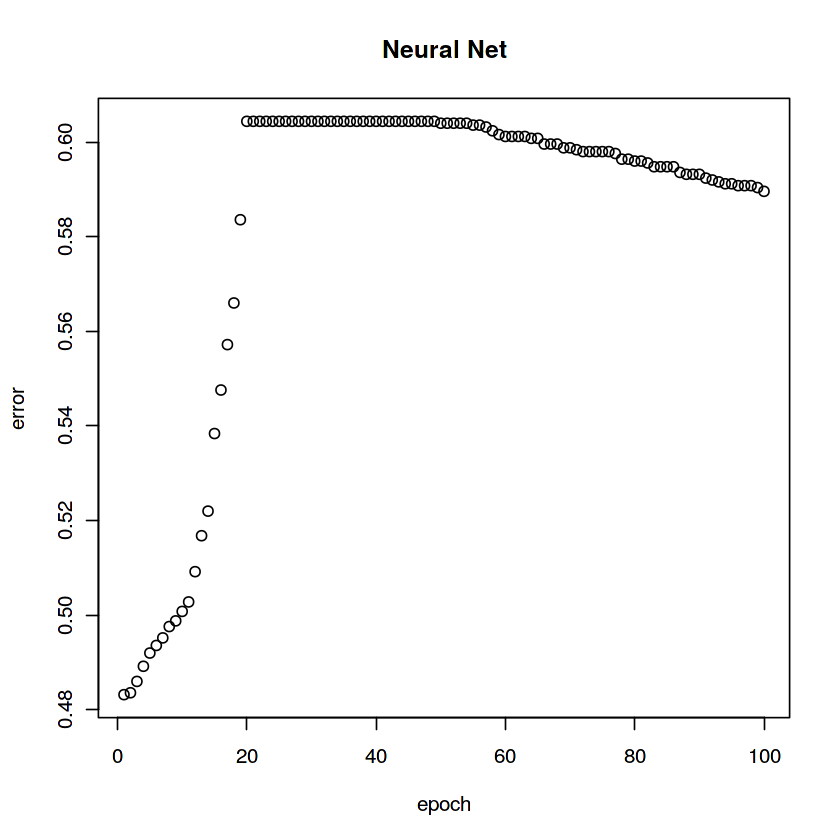

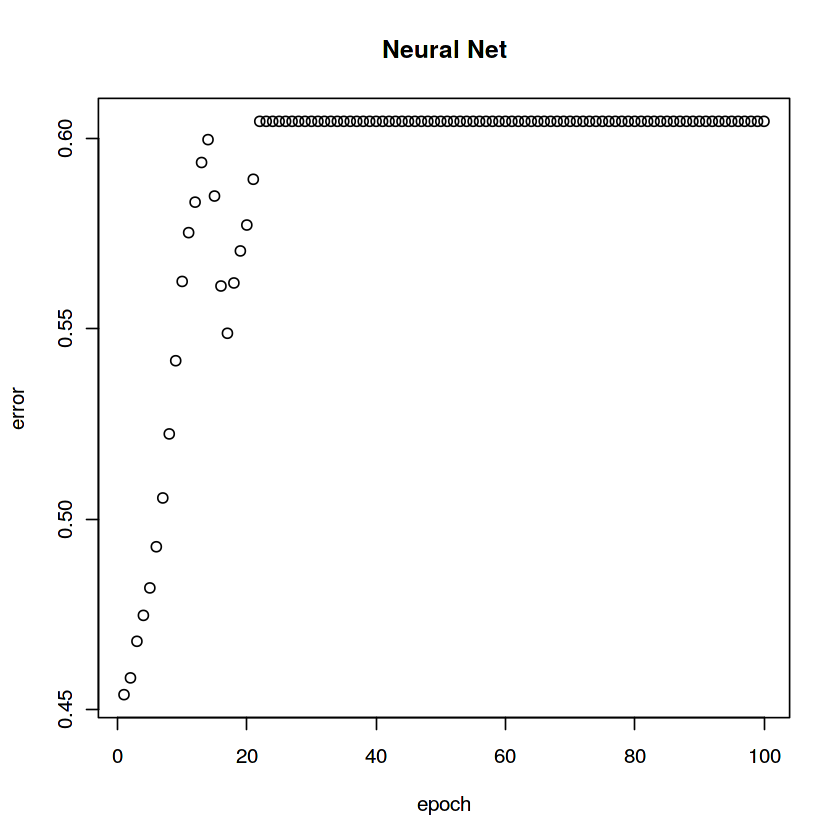

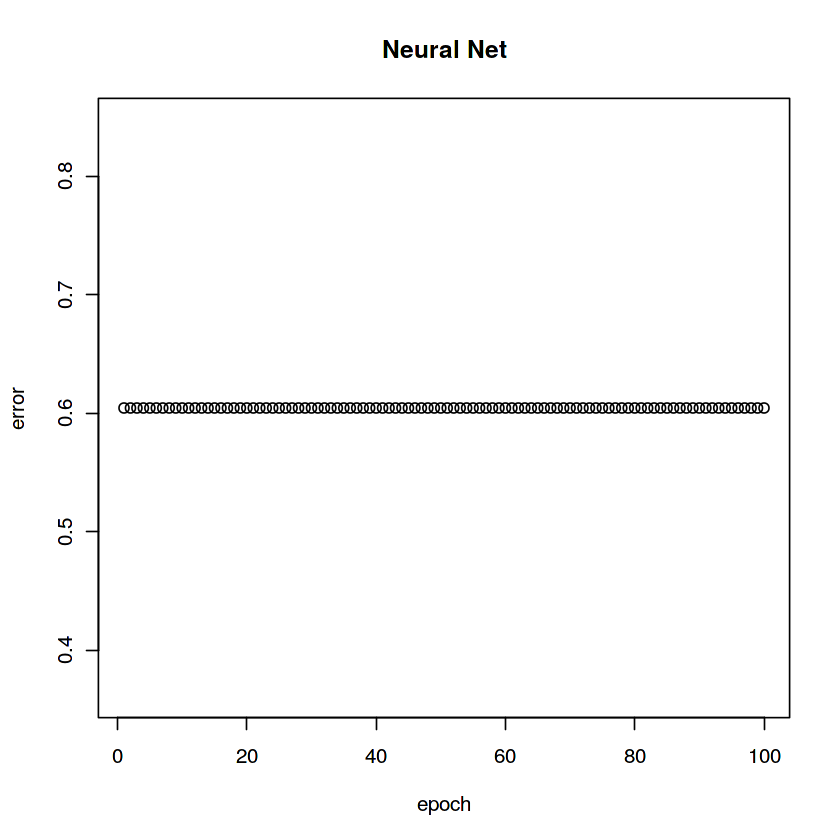

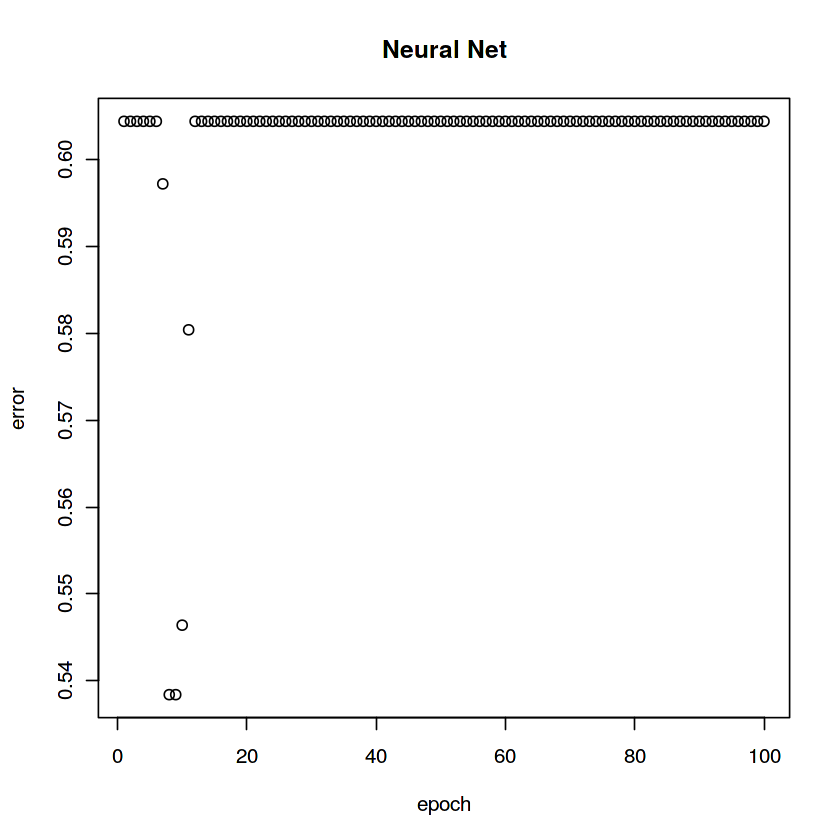

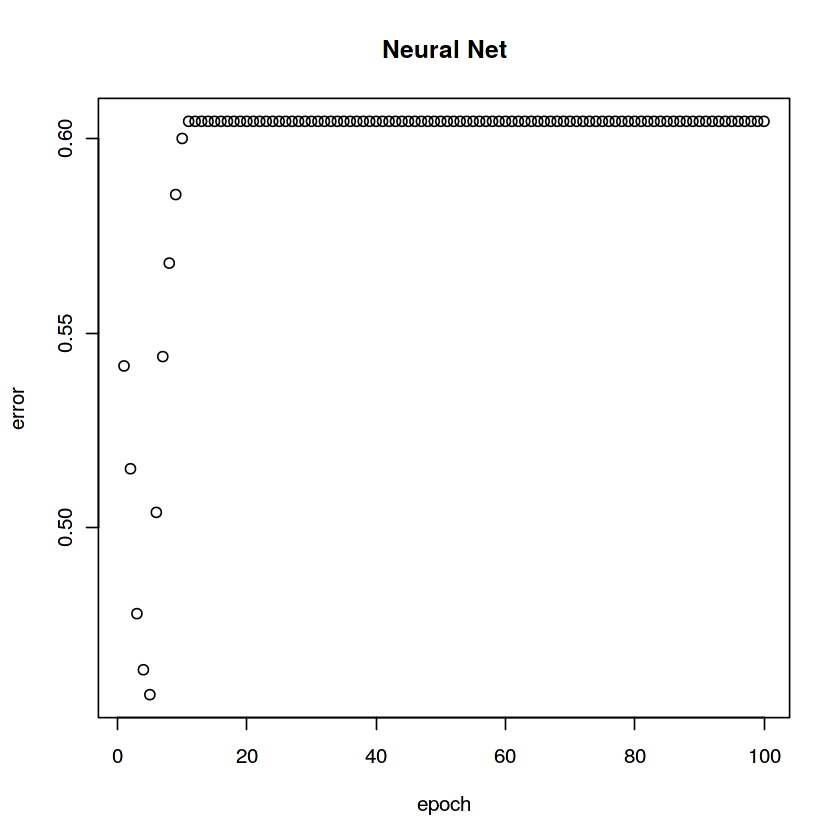

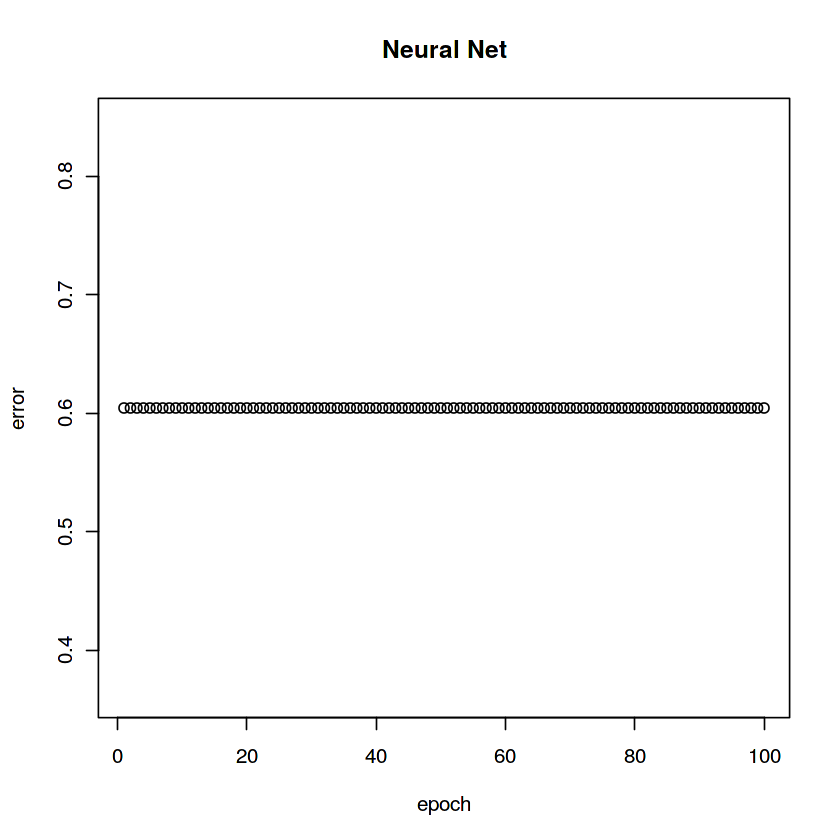

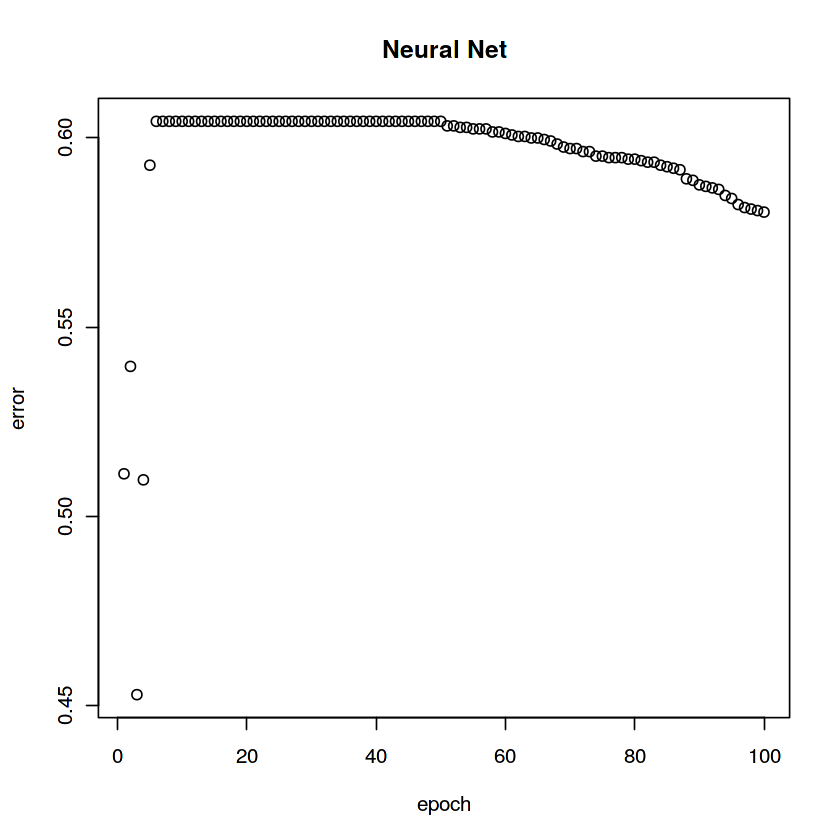

In [12]:
#? Build a number of Neural Networks with different number of units in the hidden layer (TO BE COMPLETE)

X1.t <- t(as.matrix(X1))
X2.t <- t(as.matrix(X2))
for (k in seq.vec) {
  list[W1, W2, b1, b2]<- nn.build(k, X1.t, T1, plotting=TRUE, epoch.max=100, eta = 0.1, lambda = 0.01)
  #? Evaluate the model (TO BE COMPLETE)
    predict.label <- nn.predict(X2.t,W1,W2,b1,b2)
  
  #? Record the test errors for plotting purposes (TO BE COMPLETE)
    test.error <- sum(predict.label!=T2)/length(T2)*100
    result[k/2,2] <- test.error
}

## 4. Plot Test Error VS K

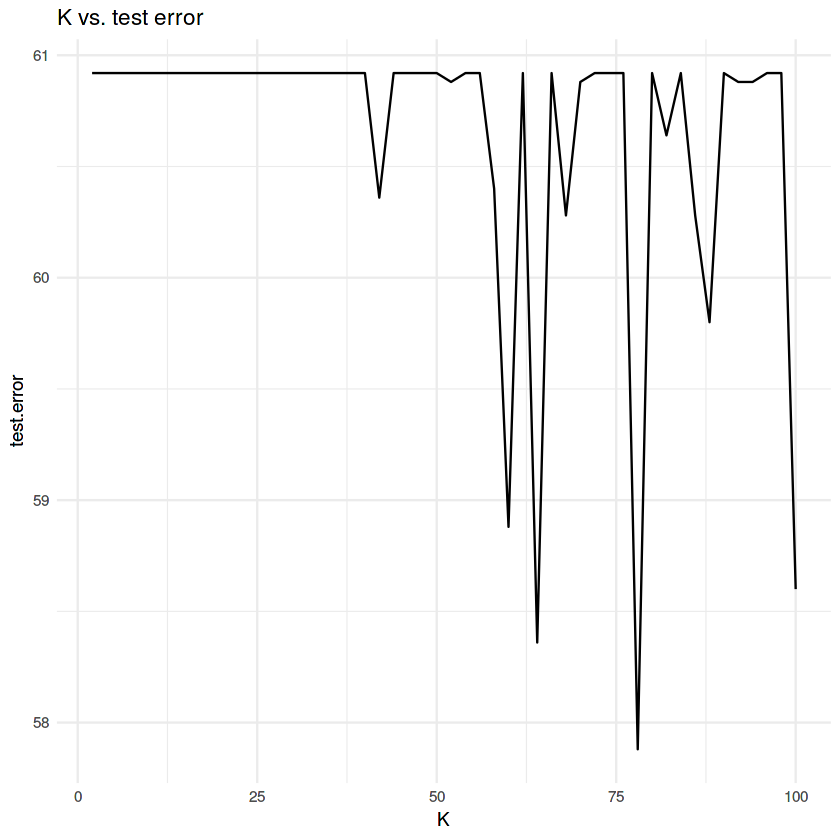

In [16]:
#? Plot the test error versus number of units i.e., k  (TO BE COMPLETE)
ggplot(data=result, aes(x=K,y=test.error)) + geom_line() +
    scale_color_discrete(guide = guide_legend(title = 'Test error'))+
    ggtitle('K vs. test error') +
    theme_minimal()

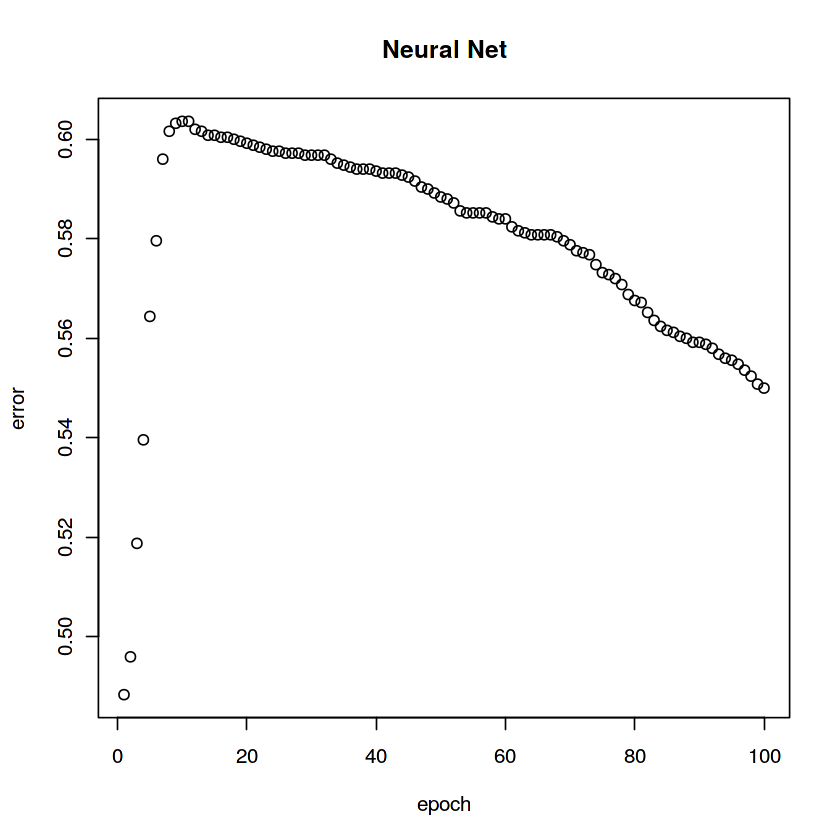

In [13]:
#? Find the k with the lowest test error (TO BE COMPLETE)
k.best <- 76
list[W1, W2, b1, b2]<- nn.build(k.best, X1.t, T1, plotting=TRUE, epoch.max=100, eta = 0.1, lambda = 0.01)
predict.label.k <- nn.predict(X2.t,W1,W2,b1,b2)

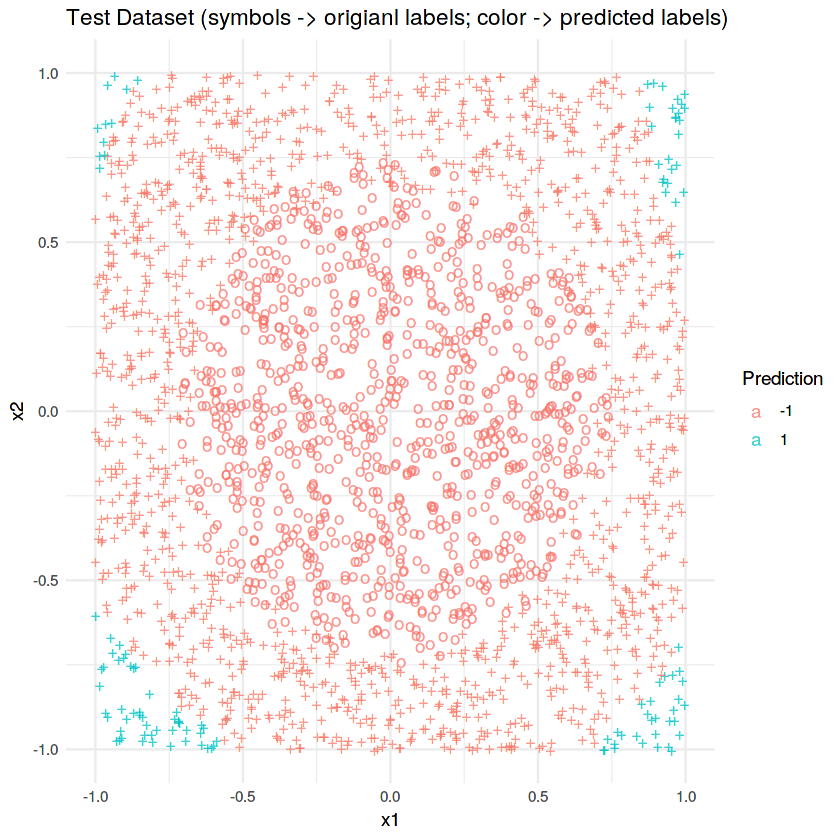

In [14]:
#? Plot Decision Boundary for NN with the lowest test error (TO BE COMPLETE)
## Hint: Plot the testing data with different symbols for each class (real labels). Then color each point based on its predicted label.
# Visualizations
## Ploting the decision boundary
ggplot(data=X2, aes(x=x1, y=x2, label=ifelse(T2!=-1, '+', 'o'), color=factor(predict.label.k))) +
    geom_text(alpha=0.75) +
    scale_color_discrete(guide = guide_legend(title = 'Prediction'))+
    ggtitle('Test Dataset (symbols -> origianl labels; color -> predicted labels)') +
    theme_minimal()

#? save all the plots and attach them to your report. Also, add the obtained test error as a table in your report. Finally, answer the questions and explain your findings.

## 4.Table

In [17]:
model.name <- rep('Neural network',length(seq.vec), each = 1)
nn.data <- cbind(model.name, result)
pr.data <- unname(data.frame('Perceptron','NA',0.514))
names(pr.data) <- c('model.name','K','test.error')
all.data <- rbind(nn.data,pr.data)

In [18]:
all.data

model.name     K   test.error
1  Neural network 2   60.920    
2  Neural network 4   60.920    
3  Neural network 6   60.920    
4  Neural network 8   60.920    
5  Neural network 10  60.920    
6  Neural network 12  60.920    
7  Neural network 14  60.920    
8  Neural network 16  60.920    
9  Neural network 18  60.920    
10 Neural network 20  60.920    
11 Neural network 22  60.920    
12 Neural network 24  60.920    
13 Neural network 26  60.920    
14 Neural network 28  60.920    
15 Neural network 30  60.920    
16 Neural network 32  60.920    
17 Neural network 34  60.920    
18 Neural network 36  60.920    
19 Neural network 38  60.920    
20 Neural network 40  60.920    
21 Neural network 42  60.360    
22 Neural network 44  60.920    
23 Neural network 46  60.920    
24 Neural network 48  60.920    
25 Neural network 50  60.920    
26 Neural network 52  60.880    
27 Neural network 54  60.920    
28 Neural network 56  60.920    
29 Neural network 58  60.400    
30 Neural network 60  58.880    
31 Neural network 62  60.920    
32 Neural network 64  58.360    
33 Neural network 66  60.920    
34 Neural network 68  60.280    
35 Neural network 70  60.880    
36 Neural network 72  60.920    
37 Neural network 74  60.920    
38 Neural network 76  60.920    
39 Neural network 78  57.880    
40 Neural network 80  60.920    
41 Neural network 82  60.640    
42 Neural network 84  60.920    
43 Neural network 86  60.280    
44 Neural network 88  59.800    
45 Neural network 90  60.920    
46 Neural network 92  60.880    
47 Neural network 94  60.880    
48 Neural network 96  60.920    
49 Neural network 98  60.920    
50 Neural network 100 58.600    
51 Perceptron     NA   0.514

### 5. Explanation
* Perceptron is a single layer neural network which works as a linear binary classifier.
* With increase in value of hidden layer, we see better model prediction for neural network.
* Looking at the decision boundary plot, neural network is more suited to classify non linear patterns. As number of hidden layers increases test error decreases.
* Since perceptron is not appropriate for such pattern, test error is high.